In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

from scipy.integrate import odeint # 一阶常微分方程组的数值程序

import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import init
from torch.utils import data
from dtw import *
from numpy import polyfit, poly1d

In [4]:
#构建数据集

def logi(x,r): # 定义 logistic map
    return r*x*(1-x)

def logitime(x,r,m): # 生成 logistic map 训练集
    X=torch.zeros(m)
    Y=torch.zeros(m)
    for i in torch.arange(0,m):
        X[i]=x
        x=logi(x,r)
        Y[i]=x
    return X,Y

In [5]:
r3=1+2*np.sqrt(2)
x3=0.5
#去暂态
for i in range(500):
    x3=logi(x3,r3)

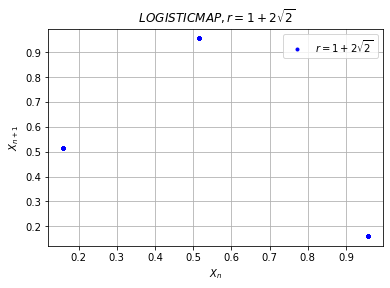

In [6]:
xt0,r0,m0=x3,r3,200
X0,Y0=logitime(xt0,r0,m0)
X0=X0.reshape(-1,1)
Y0=Y0.reshape(-1,1)
#plt.figure(figsize=(16, 8))
plt.title(" $LOGISTIC MAP,r=1+2\sqrt{2}$")
plt.xlabel("$X_{n}$")
plt.ylabel("$X_{n+1}$")
plt.plot(X0.cpu(),Y0.cpu(),'b.',label="$r=1+2\sqrt{2}$")
plt.legend(loc=0)
plt.grid(True)

In [7]:
#数据集分割
XTR0=X0[0:120];YTR0=Y0[0:120] #训练集
XTE0=X0[120:200];YTE0=Y0[120:200]  #测试集

In [7]:
def load_array(data_arrays, batch_size, is_train=False):
    dataset=data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


In [8]:
def Lya(net):   #定义李指数
    XM=torch.linspace(0,1,100)
    XM=XM.reshape(100,1)
    YM=torch.ones(100)
    for i in range(100):
        net.eval()
        YM[i]=net(XM[i])
    coeff=polyfit(XM.detach().numpy().reshape(100),YM.detach().numpy().reshape(100),6)
    f=poly1d(coeff)
    df=f.deriv()
    df
    LYN=2000
    dx=0
    x1=torch.tensor([0.107])
    for i in range(2000):    #去暂态
        net.eval()
        x1=net(x1)
    for i in range(LYN):
        dx=dx+np.log(np.abs(df(x1.detach().numpy())))
        net.eval()
        x1=net(x1)
    L=dx/LYN
    return L,YM.detach().numpy()

In [9]:
def evaluation(net):    #定义距离计算
    r0=1+2*np.sqrt(2)
    logi_array=np.zeros(100)
    x0=0.2
    for i in range(500):
        x0=logi(x0,r0)
    for i in range(100):
        x0=logi(x0,r0)
        logi_array[i]=x0
    initial_tensor=torch.tensor([[0.2]])
    net.eval()
    period=torch.zeros(100)
    for i in range(100*6):
        with torch.no_grad():
            initial_tensor=Variable(initial_tensor)
            initial_tensor=net(initial_tensor)
            if i >= 500:
                period[i-500]=initial_tensor.item()
    period_array=period.detach().numpy()
    logi_array=logi_array.reshape(-1,1)
    period_array=period_array.reshape(-1,1)
    manhattan_distance = lambda logi_array, period_array: np.abs(logi_array - period_array)
    distance, cost_matrix, acc_cost_matrix, path = dtw(logi_array, period_array, dist=manhattan_distance)
    return distance

In [10]:
def train_epoch_ann(net,train_iter,XTR,YTR,criterion,optimizer):
    net.train()
    for X,Y in train_iter:
        loss=criterion(net(X),Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses=criterion(net(XTR),YTR)
    return losses

In [11]:
def test_epoch_ann(net,XTE,YTE,criterion):
    net.eval()
    loss=criterion(net(XTE),YTE)
    return loss

In [12]:
def Bifurcation(net,num_epochs,num_period,testvalue):
    initial_tensor=torch.tensor([[testvalue]])
    net.eval()
    period=torch.zeros(num_period*2)
    for i in range(num_period*2):
        with torch.no_grad():
            initial_tensor=Variable(initial_tensor)
        initial_tensor=net(initial_tensor)
        period[i]=initial_tensor
    return period[num_period:]
        

        

In [13]:
def train_ann(net,train_iter,XTR,YTR,XTE,YTE,num_epochs,num_period,testvalue,criterion,optimizer):
    trainloss=torch.zeros(num_epochs)
    testloss=torch.zeros(num_epochs)
    period_tensor=torch.zeros((num_epochs,num_period))
    error_array=np.zeros(num_epochs)
    LyaNum_array=np.ones(num_epochs)
    YM_array=np.zeros((num_epochs,num_period))
    for epoch in range(num_epochs):
        trainloss[epoch]=train_epoch_ann(net,train_iter,XTR,YTR,criterion,optimizer)
        testloss[epoch]=test_epoch_ann(net,XTE,YTE,criterion)
        period_tensor[epoch]=Bifurcation(net,num_epochs,num_period,testvalue)
        error_array[epoch]=evaluation(net)
        LyaNum_array[epoch],YM_array[epoch]=Lya(net)
        if (epoch+1)%100==0:
            print('*'*10)
            print('epoch{}'.format(epoch+1))
            print('train_loss is{:.8f}'.format(trainloss[epoch]),'','and','','test_loss is{:.8f}'.format(testloss[epoch])) 
    return trainloss.detach().numpy(),testloss.detach().numpy(),period_tensor.detach().numpy(),error_array,LyaNum_array,YM_array

In [9]:
batch_size=1
num_epochs=1000
num_period=100
test_value=0.5
learn_rate=0.025
N=torch.arange(1,num_epochs+1,1)

NN=torch.ones((num_epochs,num_period))
for i in range(0,num_epochs):
    a=i+1
    NN[i]=a


In [36]:
all_period=np.zeros(((14,num_epochs,num_period)))
all_train_loss=np.zeros((14,num_epochs))
all_test_loss=np.zeros((14,num_epochs))
all_error=np.zeros((14,num_epochs))
all_lya=np.zeros((14,num_epochs))
all_ym=np.zeros(((14,num_epochs,num_period)))

# Net1

In [37]:
Net1=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=0
for layer in Net1:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-0.5, 0.5, size=param_shape).astype(np.float32)) 

optimizerSGD=torch.optim.SGD(Net1.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net1,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.10553078  and  test_loss is0.10518507
**********
epoch200
train_loss is0.09964672  and  test_loss is0.09940440
**********
epoch300
train_loss is0.07460631  and  test_loss is0.07522313
**********
epoch400
train_loss is0.05721917  and  test_loss is0.05785770
**********
epoch500
train_loss is0.03943994  and  test_loss is0.03992471
**********
epoch600
train_loss is0.00000002  and  test_loss is0.00000002
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net2

In [38]:
Net2=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=1
for layer in Net2:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-1.0, 1.0, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net2.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net2,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.07591346  and  test_loss is0.07656118
**********
epoch200
train_loss is0.06173062  and  test_loss is0.06238503
**********
epoch300
train_loss is0.04221325  and  test_loss is0.04271803
**********
epoch400
train_loss is0.00000061  and  test_loss is0.00000060
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net3

In [39]:
Net3=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=2
for layer in Net3:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-1.5, 1.5, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net3.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net3,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.05791818  and  test_loss is0.05854975
**********
epoch200
train_loss is0.00000001  and  test_loss is0.00000000
**********
epoch300
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch400
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net4

In [40]:
Net4=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=3
for layer in Net4:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-2.0, 2.0, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net4.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net4,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.00049602  and  test_loss is0.00050190
**********
epoch200
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch300
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch400
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net5

In [41]:
Net5=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=4
for layer in Net5:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-2.5, 2.5, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net5.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net5,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch200
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch300
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch400
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net6

In [42]:
Net6=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=5
for layer in Net6:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-3.0,3.0, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net6.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net6,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch200
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch300
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch400
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net7

In [43]:
Net7=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=6
for layer in Net7:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-3.5,3.5, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net7.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net7,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch200
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch300
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch400
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net8

In [44]:
Net8=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=7
for layer in Net8:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-4.0,4.0, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net8.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net8,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch200
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch300
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch400
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net9

In [45]:
Net9=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=8
for layer in Net9:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-4.5,4.5, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net9.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net9,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch200
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch300
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch400
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net10

In [46]:
Net10=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=9
for layer in Net10:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-5.0,5.0, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net10.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net10,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch200
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch300
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch400
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net11

In [47]:
Net11=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=10
for layer in Net11:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-5.5,5.5, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net11.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net11,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch200
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch300
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch400
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net12

In [48]:
Net12=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=11
for layer in Net12:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-6.0,6.0, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net12.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net12,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch200
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch300
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch400
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net13

In [64]:
Net13=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=12
for layer in Net13:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-6.5,6.5, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net13.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net13,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch200
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch300
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch400
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# Net14

In [50]:
Net14=nn.Sequential(
    nn.Linear(1,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,1)
)

net_num=13
for layer in Net14:
    if isinstance(layer, nn.Linear): # 判断是否是线性层
        param_shape = layer.weight.shape
        layer.weight.data = torch.from_numpy(np.random.uniform(-7.0,7.0, size=param_shape).astype(np.float32)) 


optimizerSGD=torch.optim.SGD(Net14.parameters(),lr=learn_rate) 
criterionMSE=nn.MSELoss()
train_iter=load_array((XTR0,YTR0),batch_size)

all_train_loss[net_num],all_test_loss[net_num],all_period[net_num],all_error[net_num],all_lya[net_num],all_ym[net_num]=train_ann(Net14,train_iter,XTR0,YTR0,XTE0,YTE0,num_epochs,num_period,test_value,criterionMSE,optimizerSGD)

**********
epoch100
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch200
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch300
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch400
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch500
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch600
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch700
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch800
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch900
train_loss is0.00000000  and  test_loss is0.00000000
**********
epoch1000
train_loss is0.00000000  and  test_loss is0.00000000


# plot

In [69]:
np.save(r'C:\Users\dolin\Documents\machine learning\毕业论文\data\all bifurcation\all_period.npy',all_period)
np.save(r'C:\Users\dolin\Documents\machine learning\毕业论文\data\all bifurcation\all_train_loss.npy',all_train_loss)
np.save(r'C:\Users\dolin\Documents\machine learning\毕业论文\data\all bifurcation\all_test_loss.npy',all_test_loss)
np.save(r'C:\Users\dolin\Documents\machine learning\毕业论文\data\all bifurcation\all_error.npy',all_error)
np.save(r'C:\Users\dolin\Documents\machine learning\毕业论文\data\all bifurcation\all_lya.npy',all_lya)
np.save(r'C:\Users\dolin\Documents\machine learning\毕业论文\data\all bifurcation\all_ym.npy',all_ym)

In [1]:
all_period=np.load(r'C:\Users\dolin\Documents\machine learning\毕业论文\data\all bifurcation\all_period.npy')
all_train_loss=np.load(r'C:\Users\dolin\Documents\machine learning\毕业论文\data\all bifurcation\all_train_loss.npy')
all_test_loss=np.load(r'C:\Users\dolin\Documents\machine learning\毕业论文\data\all bifurcation\all_test_loss.npy')
all_error=np.load(r'C:\Users\dolin\Documents\machine learning\毕业论文\data\all bifurcation\all_error.npy')
all_lya=np.load(r'C:\Users\dolin\Documents\machine learning\毕业论文\data\all bifurcation\all_lya.npy')
all_ym=np.load(r'C:\Users\dolin\Documents\machine learning\毕业论文\data\all bifurcation\all_ym.npy')

# Result

## Net1 a=0.5

Text(0.5, -0.2, '(a)')

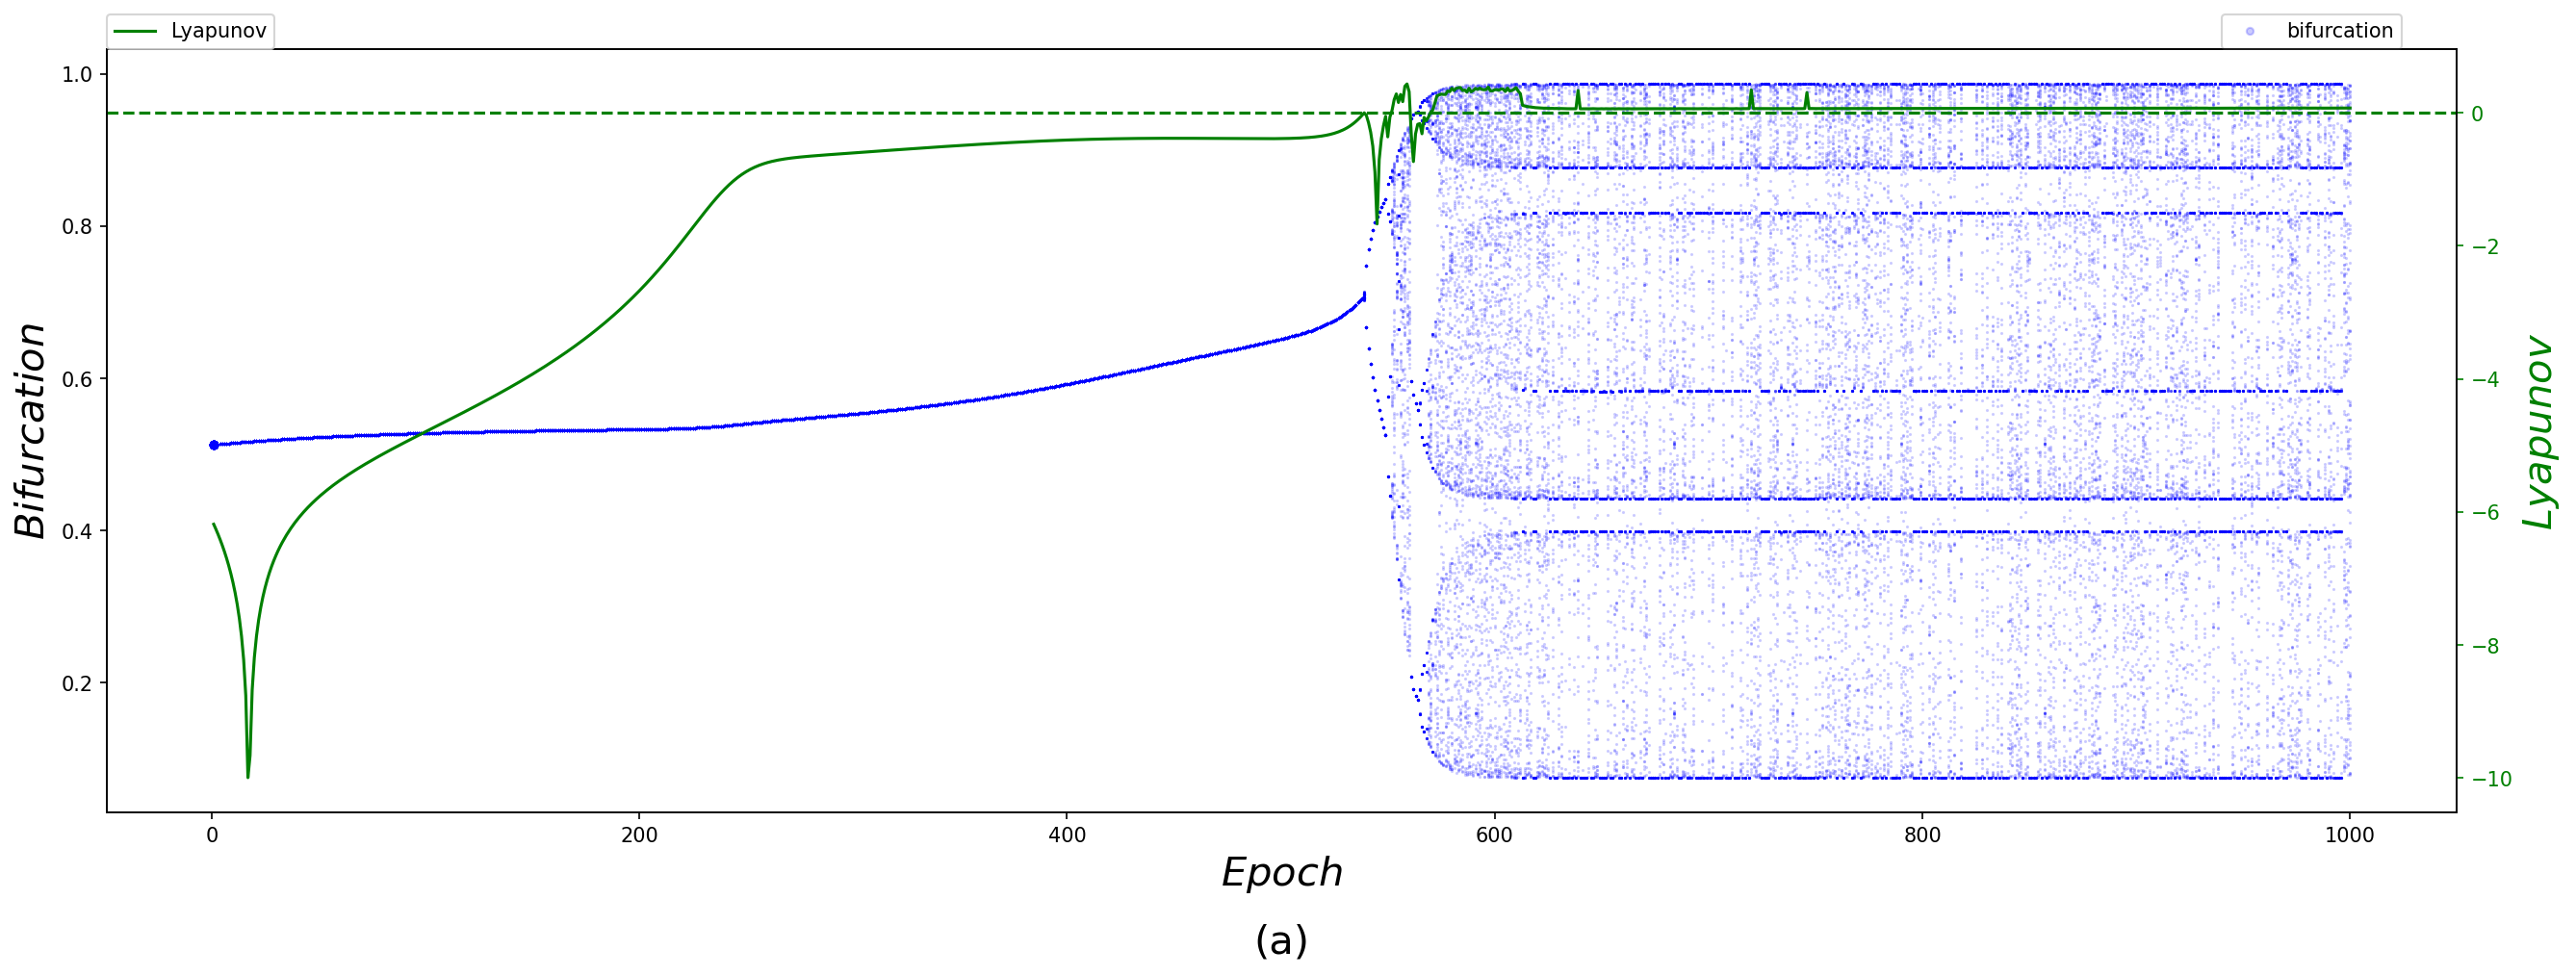

In [131]:
pet0=all_period[0]
lya0=all_lya[0]


fig,ax1=plt.subplots(figsize=(21, 7),dpi=150)
ax2=ax1.twinx()


ax1.plot(NN[0].detach().numpy(),pet0[0],'b.',alpha=0.2,markersize=7,label='bifurcation')
ax1.plot(NN.detach().numpy(),pet0,'b.',alpha=0.2,markersize=1)




ax2.plot(N.detach().numpy(),lya0,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0,1))

ax1.set_xlabel('$Epoch$',size=20)
ax1.set_ylabel('$Bifurcation$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')
plt.title('(a)',y=-0.2,size=20)

Text(0.5, -0.2, '(b)')

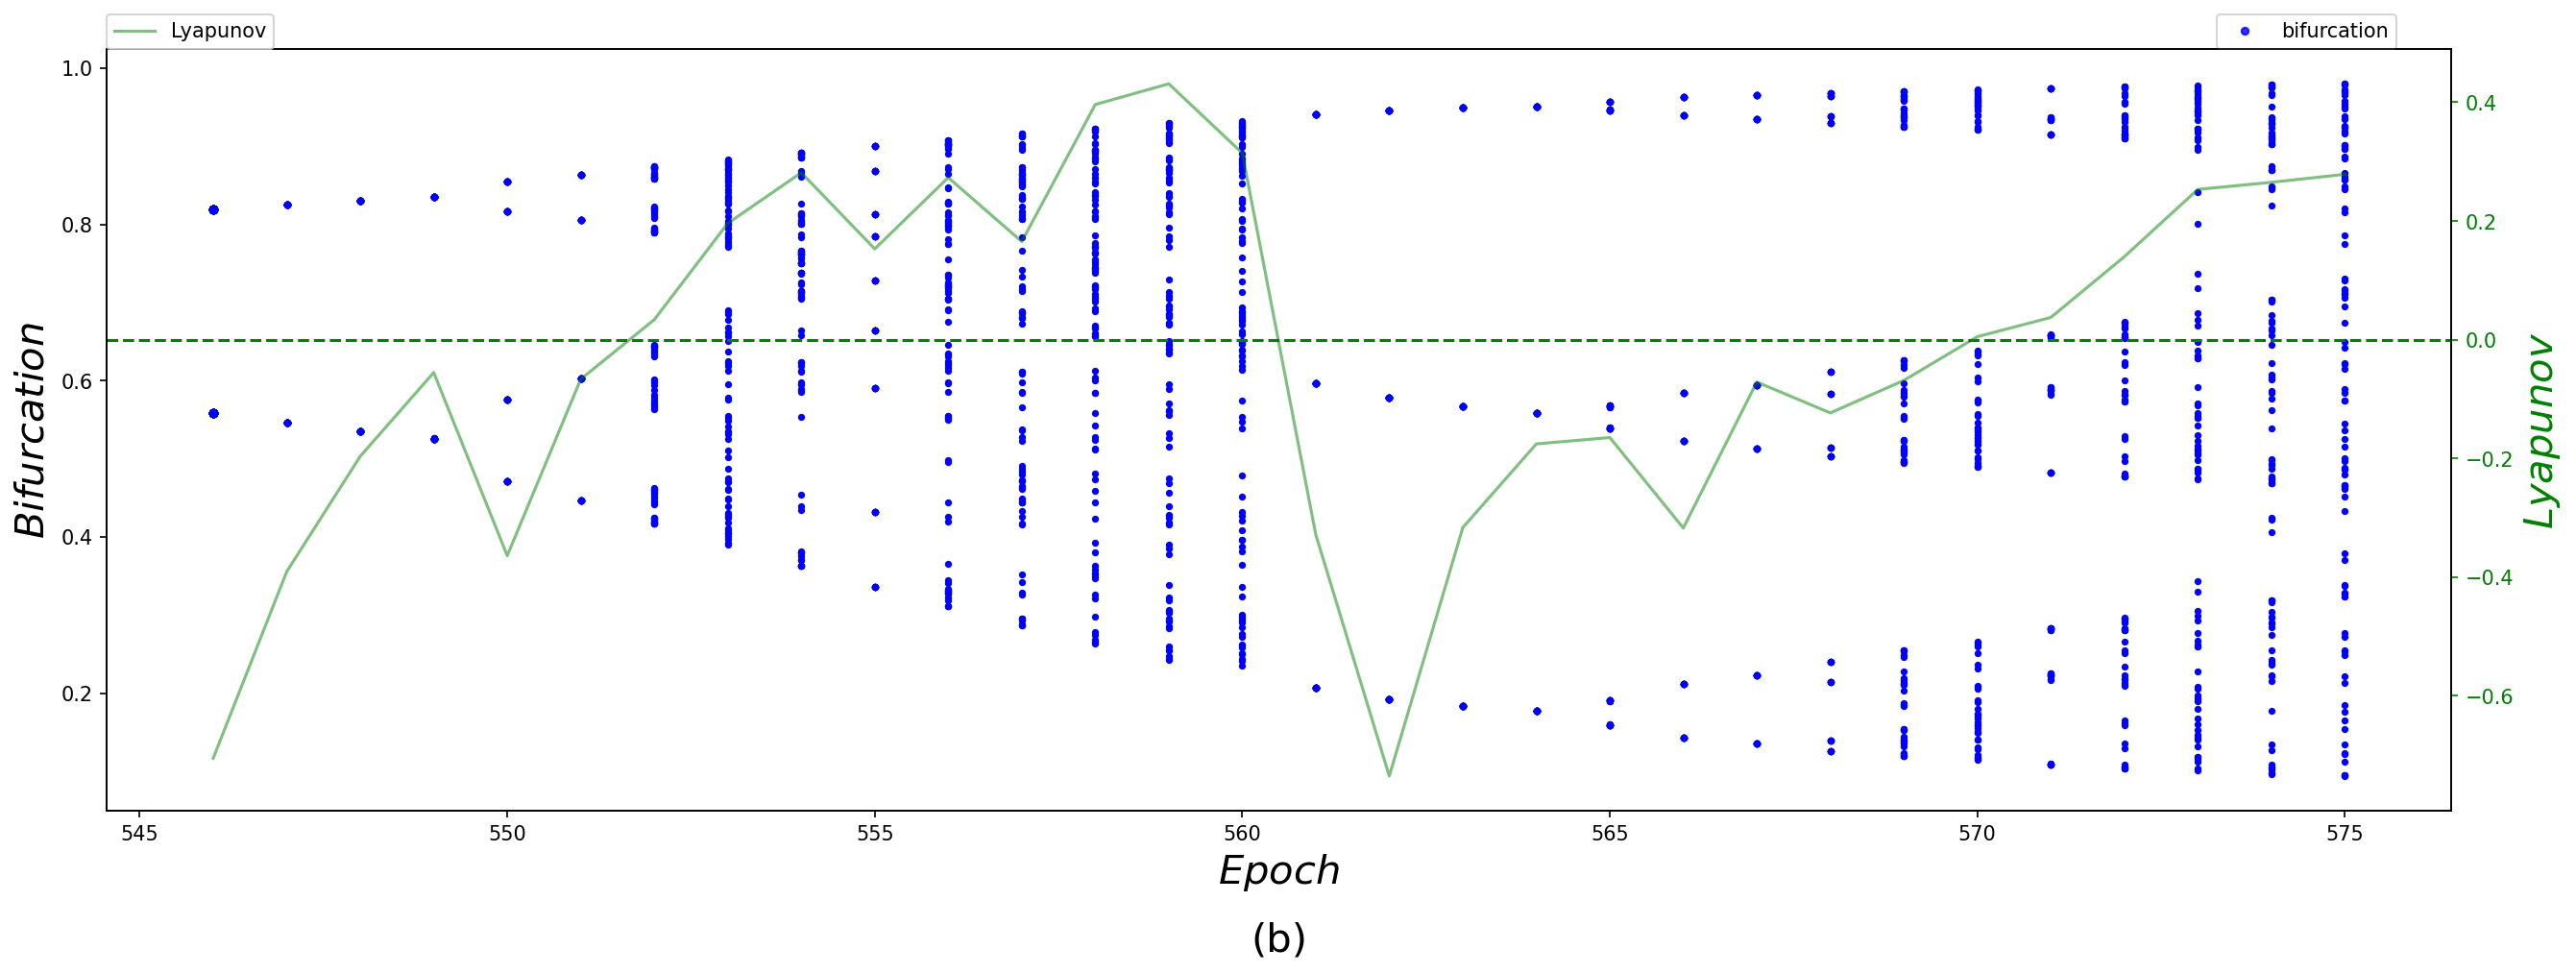

In [133]:
pet0=all_period[0]
lya0=all_lya[0]


fig,ax1=plt.subplots(figsize=(21, 7),dpi=150)
ax2=ax1.twinx()


ax1.plot(NN[545].detach().numpy(),pet0[545],'b.',alpha=0.8,markersize=7,label='bifurcation')
ax1.plot(NN[546:575].detach().numpy(),pet0[546:575],'b.',alpha=1,markersize=5)




ax2.plot(N[545:575].detach().numpy(),lya0[545:575],'green',alpha=0.5,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0,1))

ax1.set_xlabel('$Epoch$',size=20)
ax1.set_ylabel('$Bifurcation$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')
plt.title('(b)',y=-0.2,size=20)

No handles with labels found to put in legend.


Text(0.5, -0.2, '(c)')

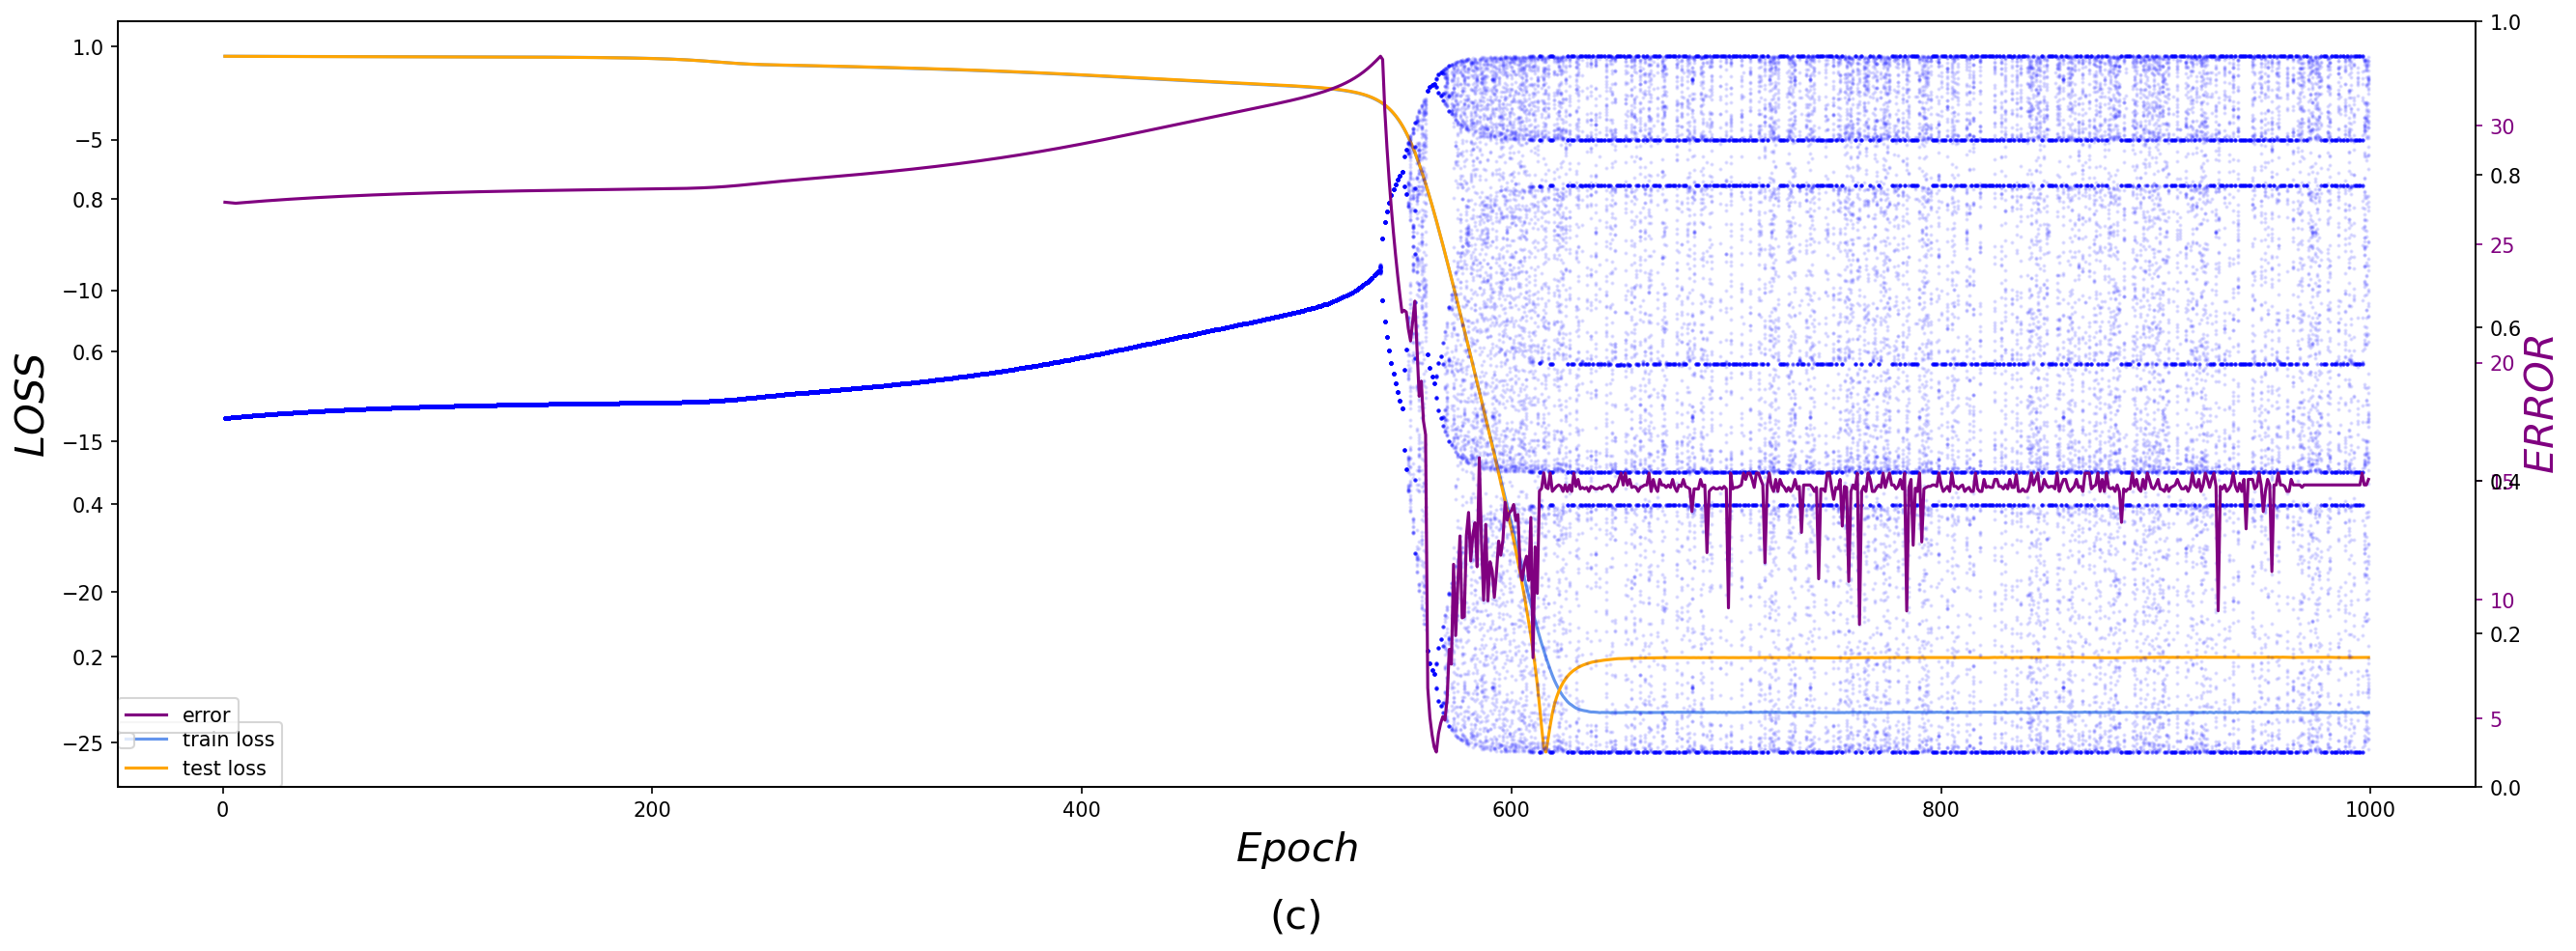

In [134]:
trl0=all_train_loss[0]
tel0=all_test_loss[0]
era0=all_error[0]
up_a=0
up_b=999


fig,ax1=plt.subplots(figsize=(21, 7),dpi=150)
ax2=ax1.twinx()

ax1.plot(N[up_a:up_b],np.log(trl0[up_a:up_b]),'cornflowerblue',label="train loss",alpha=1)    
ax1.plot(N[up_a:up_b],np.log(tel0[up_a:up_b]),'orange',label="test loss",alpha=1)

ax2.plot(NN[up_a:up_b,:],pet0[up_a:up_b,:],'b.',alpha=0.1,markersize=2)
#ax2.axhline(y=X0[0].detach().numpy(),linestyle='--',color='red',label='0.1599',alpha=0.5)
#ax2.axhline(y=X0[1].detach().numpy(),linestyle='--',color='red',label='0.5142',alpha=0.5)
#ax2.axhline(y=X0[2].detach().numpy(),linestyle='--',color='red',label='0.9563',alpha=0.5)
#ax2.tick_params(axis='y',colors='red')

ax3=ax1.twinx()
ax3.plot(N[up_a:up_b].detach().numpy(),era0[up_a:up_b],'purple',label="error",alpha=1)
#ax3.axvline(x=np.argmin(era)+1,linestyle='--',alpha=1)
ax3.tick_params(axis='y',colors='purple')

ax4=ax2.twinx()
#ax4.plot(N[up_a:up_b].detach().numpy(),lya0[up_a:up_b],'green',alpha=1,markersize=1,label='Lyapunov')
#ax4.axhline(y=0,color='green',linestyle='--')
#ax4.axvline(x=81,linestyle='--',alpha=1,color='green')
#ax4.tick_params(axis='y',colors='green')


ax1.legend(loc=(0,0))
ax2.legend(loc=(0,0.05))
ax3.legend(loc=(0,0.07))
#ax4.legend(loc=(0,0.154))

ax1.set_xlabel('$Epoch$',size=20)
ax1.set_ylabel('$LOSS$',size=20)
#ax2.set_ylabel('$Period-3$',size=20,color='red',loc='bottom')
ax3.set_ylabel('$ERROR$',size=20,color='purple',loc='center')
#ax4.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')
plt.title('(c)',y=-0.2,size=20)

Text(0.5, -0.2, '(d)')

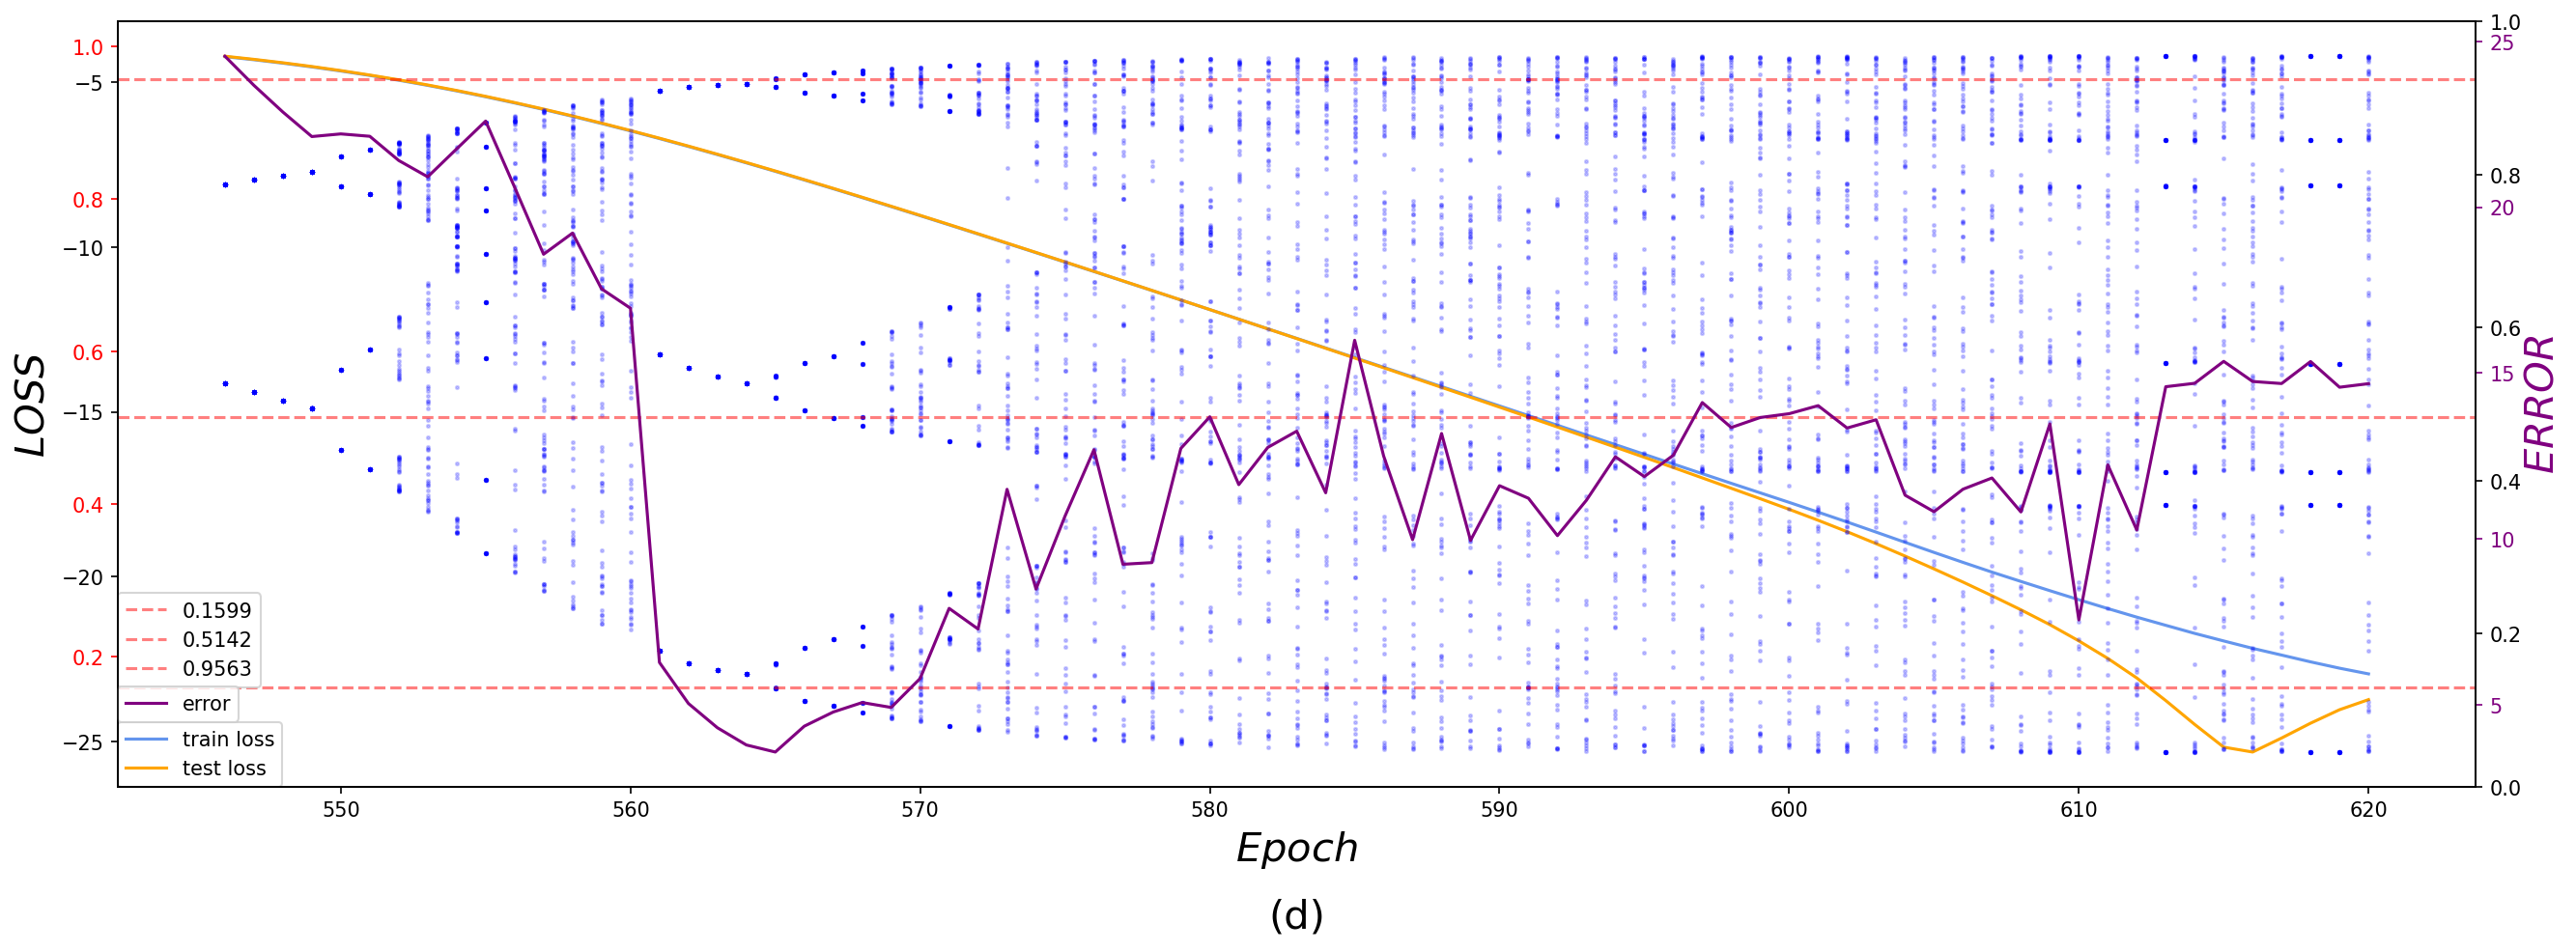

In [156]:
trl0=all_train_loss[0]
tel0=all_test_loss[0]
era0=all_error[0]
up_a=545
up_b=620


fig,ax1=plt.subplots(figsize=(21, 7),dpi=150)
ax2=ax1.twinx()

ax1.plot(N[up_a:up_b],np.log(trl0[up_a:up_b]),'cornflowerblue',label="train loss",alpha=1)    
ax1.plot(N[up_a:up_b],np.log(tel0[up_a:up_b]),'orange',label="test loss",alpha=1)

ax2.plot(NN[up_a:up_b,:],pet0[up_a:up_b,:],'b.',alpha=0.2,markersize=3)
ax2.axhline(y=X0[0].detach().numpy(),linestyle='--',color='red',label='0.1599',alpha=0.5)
ax2.axhline(y=X0[1].detach().numpy(),linestyle='--',color='red',label='0.5142',alpha=0.5)
ax2.axhline(y=X0[2].detach().numpy(),linestyle='--',color='red',label='0.9563',alpha=0.5)
ax2.tick_params(axis='y',colors='red')

ax3=ax1.twinx()
ax3.plot(N[up_a:up_b].detach().numpy(),era0[up_a:up_b],'purple',label="error",alpha=1)
#ax3.axvline(x=np.argmin(era)+1,linestyle='--',alpha=1)
ax3.tick_params(axis='y',colors='purple')

ax4=ax2.twinx()
#ax4.plot(N[up_a:up_b].detach().numpy(),lya0[up_a:up_b],'green',alpha=1,markersize=1,label='Lyapunov')
#ax4.axhline(y=0,color='green',linestyle='--')
#ax4.axvline(x=81,linestyle='--',alpha=1,color='green')
#ax4.tick_params(axis='y',colors='green')


ax1.legend(loc=(0,0))
ax2.legend(loc=(0,0.13))
ax3.legend(loc=(0,0.085))
#ax4.legend(loc=(0,0.154))

ax1.set_xlabel('$Epoch$',size=20)
ax1.set_ylabel('$LOSS$',size=20)
#ax2.set_ylabel('$Period-3$',size=20,color='red',loc='bottom')
ax3.set_ylabel('$ERROR$',size=20,color='purple',loc='center')
plt.title('(d)',y=-0.2,size=20)



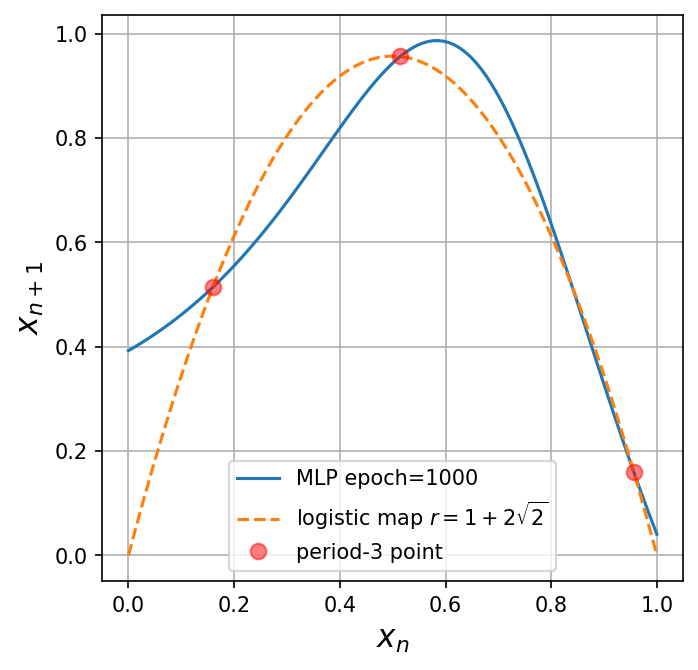

In [118]:
def logi(x,r): # 定义 logistic map
    return r*x*(1-x)

def logitime(x,r,m): # 生成 logistic map 训练集
    X=np.zeros(m)
    Y=np.zeros(m)
    for i in torch.arange(0,m):
        X[i]=x
        x=logi(x,r)
        Y[i]=x
    return X,Y

r3=1+2*np.sqrt(2)
x3=0.5
#去暂态
for i in range(500):
    x3=logi(x3,r3)

xt0,r0,m0=x3,r3,200
X0,Y0=logitime(xt0,r0,m0)
X0=X0.reshape(-1,1)
Y0=Y0.reshape(-1,1)

def LogisticMapFunction(x,r): # 定义 logistic map
    return r*x*(1-x)

xx=np.linspace(0,1,100)
yy01=all_ym[0,999]
yy=LogisticMapFunction(xx,1+2*np.sqrt(2))
plt.figure(figsize=(5,5),dpi=150)
plt.plot(xx,yy01,label='MLP epoch=1000')
plt.plot(xx,yy,'--',label='logistic map $r=1+2\sqrt{2}$')

plt.plot(X0[0],X0[1],'r.',markersize=15,alpha=0.5,label='period-3 point')
plt.plot(X0[1],X0[2],'r.',markersize=15,alpha=0.5)
plt.plot(X0[2],X0[3],'r.',markersize=15,alpha=0.5)
plt.xlabel('$x_n$',size=15)
plt.ylabel('$x_{n+1}$',size=15)
plt.legend(loc=0)
plt.grid(True)

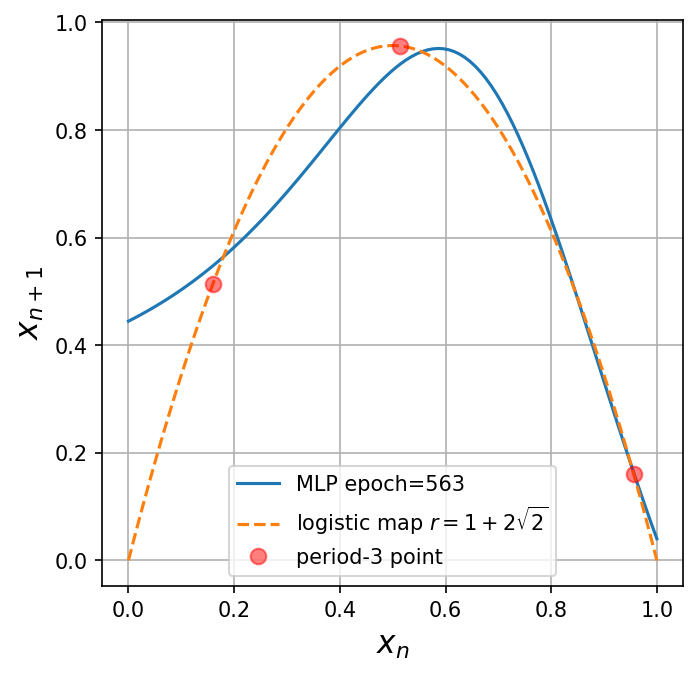

In [143]:
def logi(x,r): # 定义 logistic map
    return r*x*(1-x)

def logitime(x,r,m): # 生成 logistic map 训练集
    X=np.zeros(m)
    Y=np.zeros(m)
    for i in torch.arange(0,m):
        X[i]=x
        x=logi(x,r)
        Y[i]=x
    return X,Y

r3=1+2*np.sqrt(2)
x3=0.5
#去暂态
for i in range(500):
    x3=logi(x3,r3)

xt0,r0,m0=x3,r3,200
X0,Y0=logitime(xt0,r0,m0)
X0=X0.reshape(-1,1)
Y0=Y0.reshape(-1,1)

def LogisticMapFunction(x,r): # 定义 logistic map
    return r*x*(1-x)

xx=np.linspace(0,1,100)
yy0=all_ym[0,562]
yy=LogisticMapFunction(xx,1+2*np.sqrt(2))
plt.figure(figsize=(5,5),dpi=150)
plt.plot(xx,yy0,label='MLP epoch=563')
plt.plot(xx,yy,'--',label='logistic map $r=1+2\sqrt{2}$')

plt.plot(X0[0],X0[1],'r.',markersize=15,alpha=0.5,label='period-3 point')
plt.plot(X0[1],X0[2],'r.',markersize=15,alpha=0.5)
plt.plot(X0[2],X0[3],'r.',markersize=15,alpha=0.5)
plt.xlabel('$x_n$',size=15)
plt.ylabel('$x_{n+1}$',size=15)
plt.legend(loc=0)
plt.grid(True)

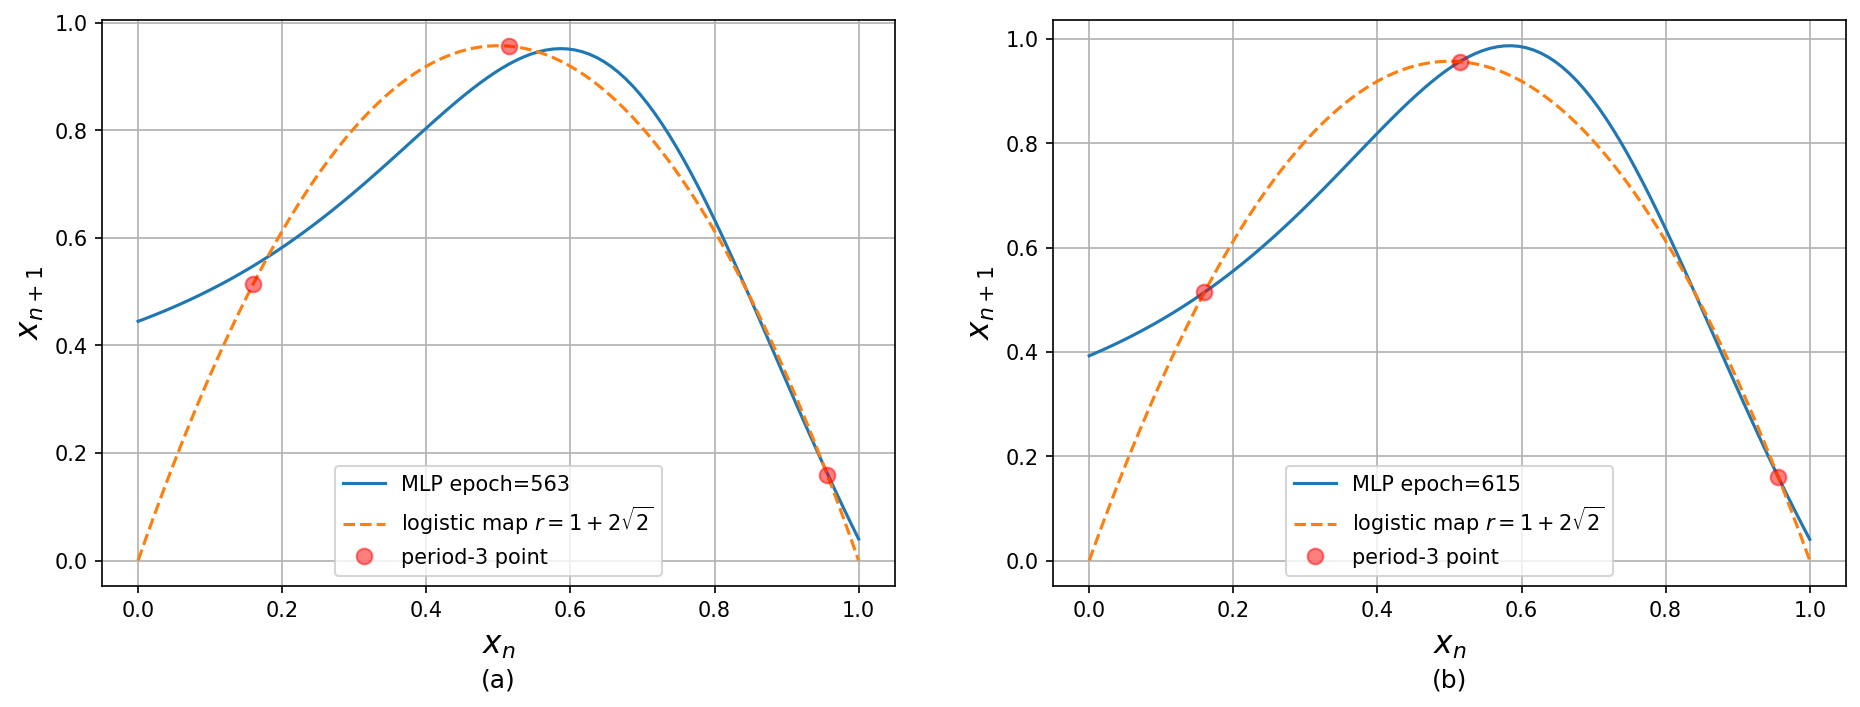

In [146]:
plt.figure(figsize=(15,5),dpi=150)




plt.subplot(121)
xx=np.linspace(0,1,100)
yy0=all_ym[0,562]
yy=LogisticMapFunction(xx,1+2*np.sqrt(2))
plt.plot(xx,yy0,label='MLP epoch=563')
plt.plot(xx,yy,'--',label='logistic map $r=1+2\sqrt{2}$')

plt.plot(X0[0],X0[1],'r.',markersize=15,alpha=0.5,label='period-3 point')
plt.plot(X0[1],X0[2],'r.',markersize=15,alpha=0.5)
plt.plot(X0[2],X0[3],'r.',markersize=15,alpha=0.5)
plt.xlabel('$x_n$',size=15)
plt.ylabel('$x_{n+1}$',size=15)
plt.legend(loc=0)
plt.title('(a)',y=-0.2)
plt.grid(True)

plt.subplot(122)
xx=np.linspace(0,1,100)
yy01=all_ym[0,615]
yy=LogisticMapFunction(xx,1+2*np.sqrt(2))
plt.plot(xx,yy01,label='MLP epoch=615')
plt.plot(xx,yy,'--',label='logistic map $r=1+2\sqrt{2}$')

plt.plot(X0[0],X0[1],'r.',markersize=15,alpha=0.5,label='period-3 point')
plt.plot(X0[1],X0[2],'r.',markersize=15,alpha=0.5)
plt.plot(X0[2],X0[3],'r.',markersize=15,alpha=0.5)
plt.xlabel('$x_n$',size=15)
plt.ylabel('$x_{n+1}$',size=15)
plt.legend(loc=0)
plt.title('(b)',y=-0.2)
plt.grid(True)

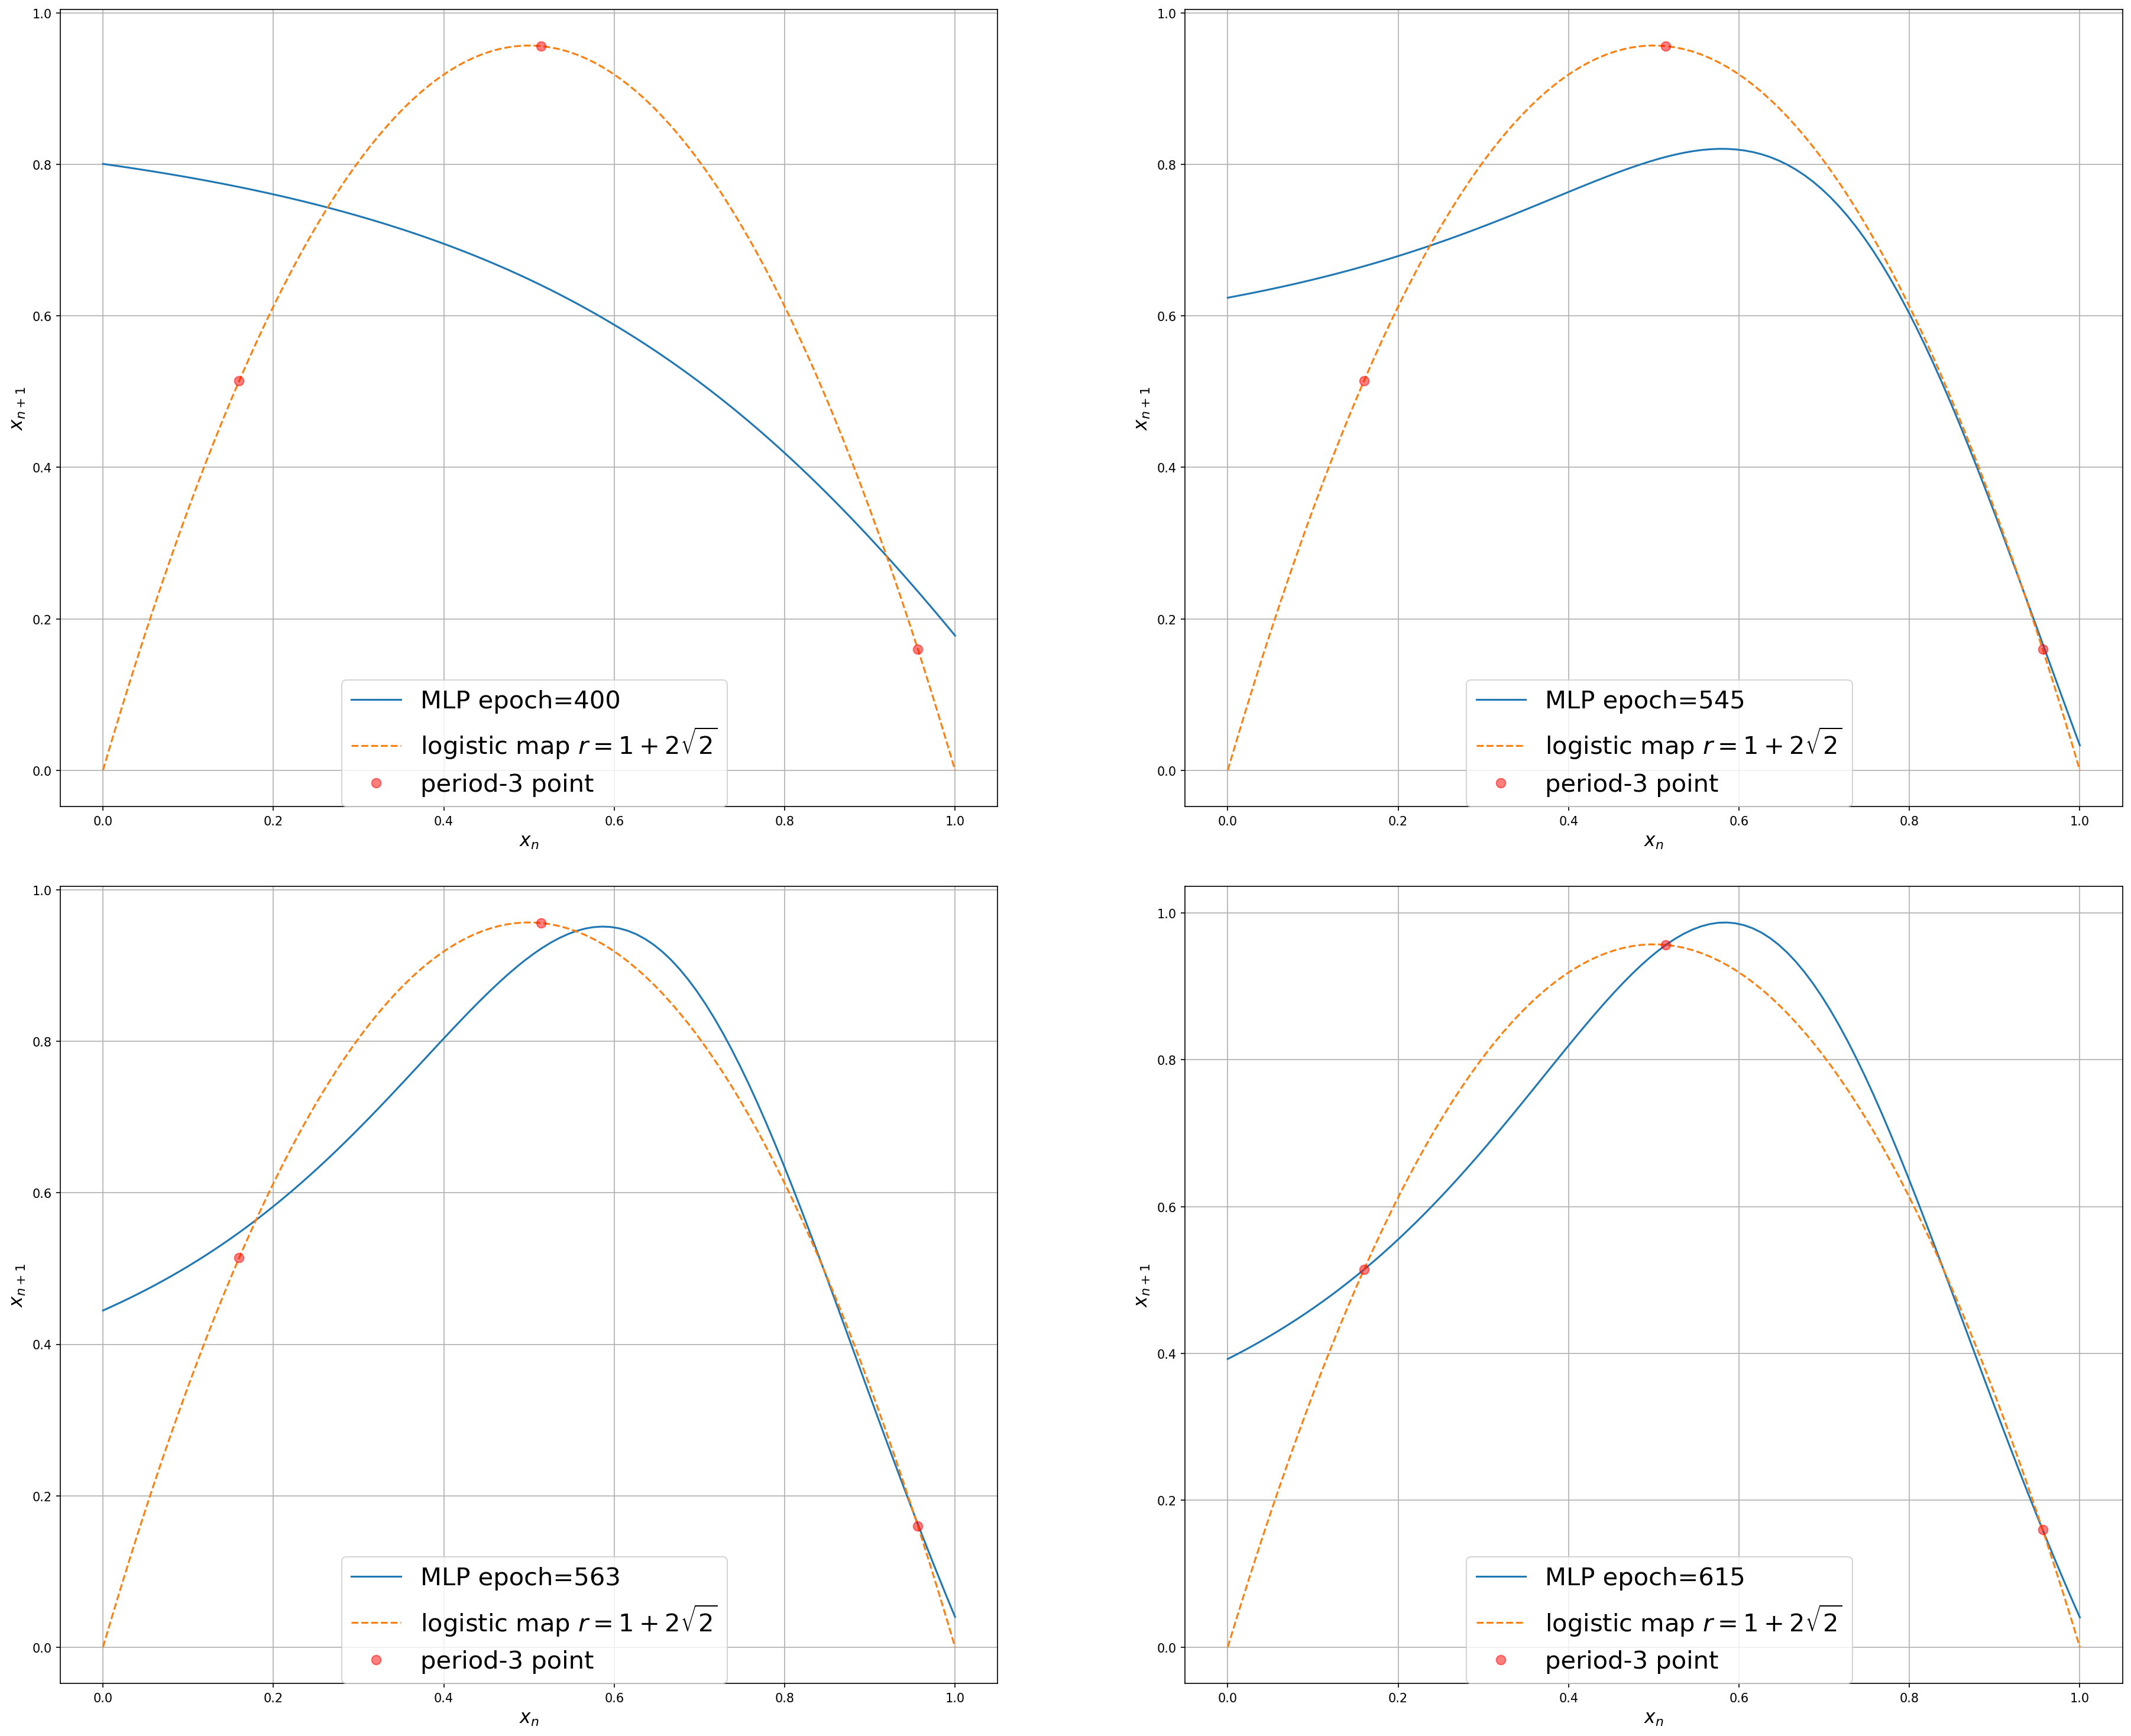

In [88]:
plt.figure(figsize=(30,25),dpi=150)
plt.subplots_adjust(hspace=0.1)
plt.subplot(221)
xx=np.linspace(0,1,100)
yy0=all_ym[0,400]
yy=LogisticMapFunction(xx,1+2*np.sqrt(2))
plt.plot(xx,yy0,label='MLP epoch=400')
plt.plot(xx,yy,'--',label='logistic map $r=1+2\sqrt{2}$')

plt.plot(X0[0],X0[1],'r.',markersize=15,alpha=0.5,label='period-3 point')
plt.plot(X0[1],X0[2],'r.',markersize=15,alpha=0.5)
plt.plot(X0[2],X0[3],'r.',markersize=15,alpha=0.5)
plt.xlabel('$x_n$',size=15)
plt.ylabel('$x_{n+1}$',size=15)
plt.legend(loc=(0.3,0),fontsize=20)
#plt.title('(a)',y=-0.2)
plt.grid(True)

plt.subplot(222)
xx=np.linspace(0,1,100)
yy0=all_ym[0,545]
yy=LogisticMapFunction(xx,1+2*np.sqrt(2))
plt.plot(xx,yy0,label='MLP epoch=545')
plt.plot(xx,yy,'--',label='logistic map $r=1+2\sqrt{2}$')

plt.plot(X0[0],X0[1],'r.',markersize=15,alpha=0.5,label='period-3 point')
plt.plot(X0[1],X0[2],'r.',markersize=15,alpha=0.5)
plt.plot(X0[2],X0[3],'r.',markersize=15,alpha=0.5)
plt.xlabel('$x_n$',size=15)
plt.ylabel('$x_{n+1}$',size=15)
plt.legend(loc=(0.3,0),fontsize=20)
#plt.title('(a)',y=-0.2)
plt.grid(True)



plt.subplot(223)
xx=np.linspace(0,1,100)
yy0=all_ym[0,562]
yy=LogisticMapFunction(xx,1+2*np.sqrt(2))
plt.plot(xx,yy0,label='MLP epoch=563')
plt.plot(xx,yy,'--',label='logistic map $r=1+2\sqrt{2}$')

plt.plot(X0[0],X0[1],'r.',markersize=15,alpha=0.5,label='period-3 point')
plt.plot(X0[1],X0[2],'r.',markersize=15,alpha=0.5)
plt.plot(X0[2],X0[3],'r.',markersize=15,alpha=0.5)
plt.xlabel('$x_n$',size=15)
plt.ylabel('$x_{n+1}$',size=15)
plt.legend(loc=(0.3,0),fontsize=20)
#plt.title('(a)',y=-0.2)
plt.grid(True)

plt.subplot(224)
xx=np.linspace(0,1,100)
yy01=all_ym[0,615]
yy=LogisticMapFunction(xx,1+2*np.sqrt(2))
plt.plot(xx,yy01,label='MLP epoch=615')
plt.plot(xx,yy,'--',label='logistic map $r=1+2\sqrt{2}$')

plt.plot(X0[0],X0[1],'r.',markersize=15,alpha=0.5,label='period-3 point')
plt.plot(X0[1],X0[2],'r.',markersize=15,alpha=0.5)
plt.plot(X0[2],X0[3],'r.',markersize=15,alpha=0.5)
plt.xlabel('$x_n$',size=15)
plt.ylabel('$x_{n+1}$',size=15)
plt.legend(loc=(0.3,0),fontsize=20)
#plt.title('(b)',y=-0.2)
plt.grid(True)

## Net2 a=1.0

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

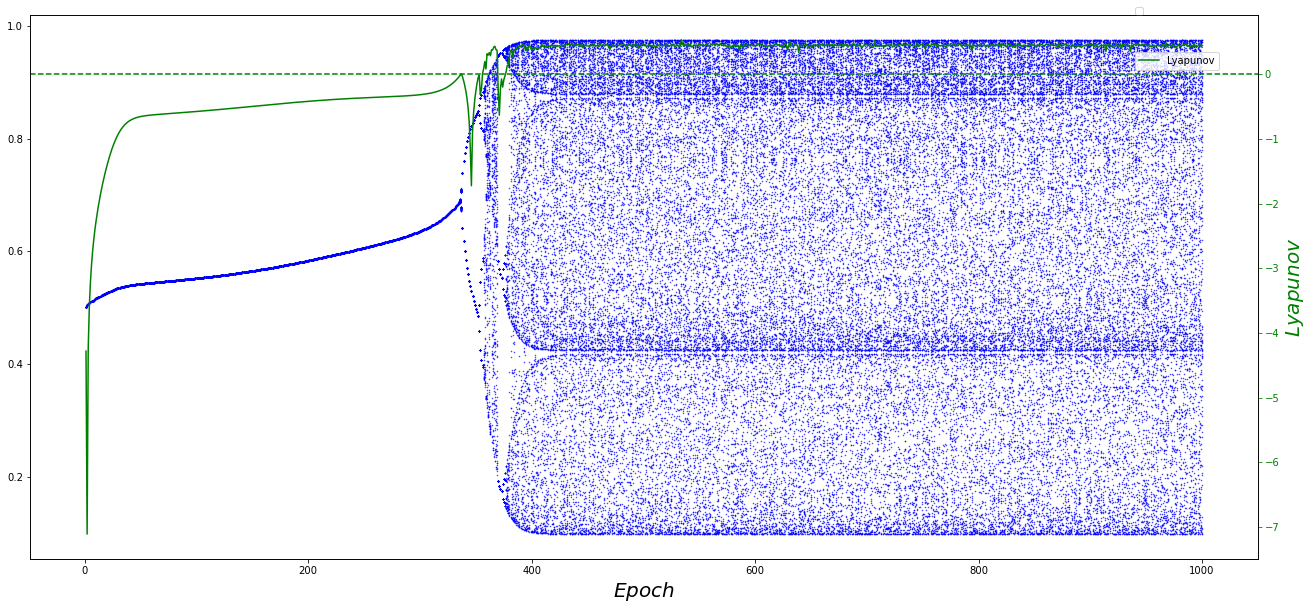

In [40]:
pet1=all_period[1]
lya1=all_lya[1]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet1,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya1,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

## Net3 a=1.5

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

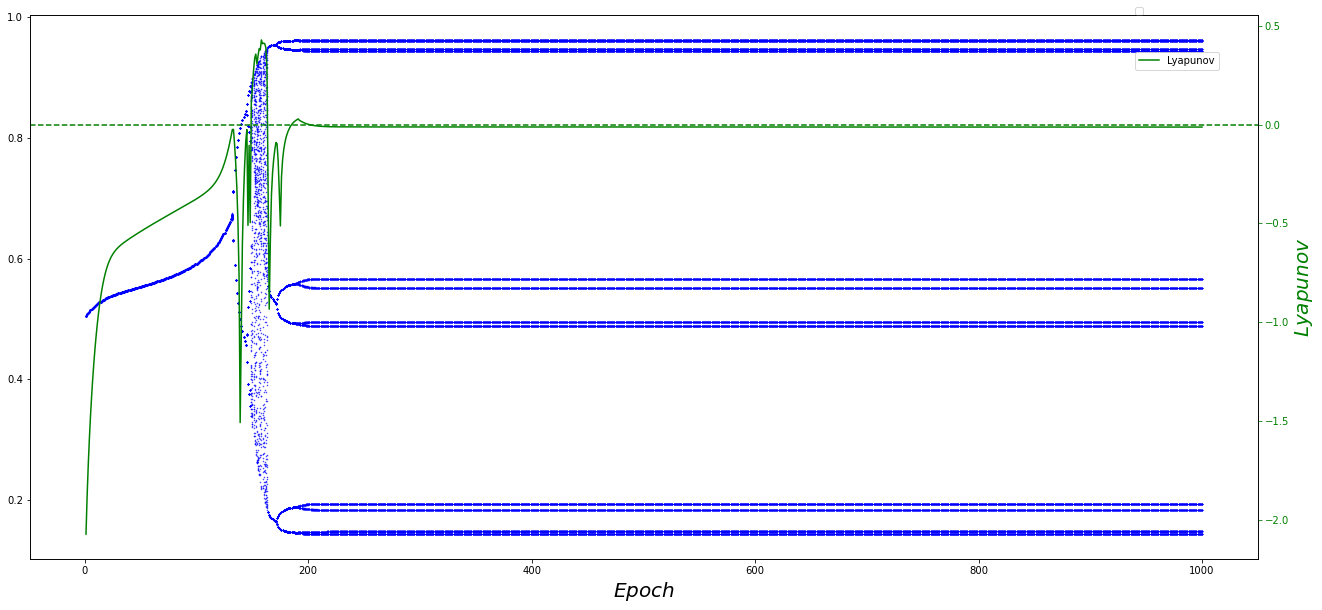

In [41]:
pet2=all_period[2]
lya2=all_lya[2]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet2,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya2,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

## Net4 a=2.0

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

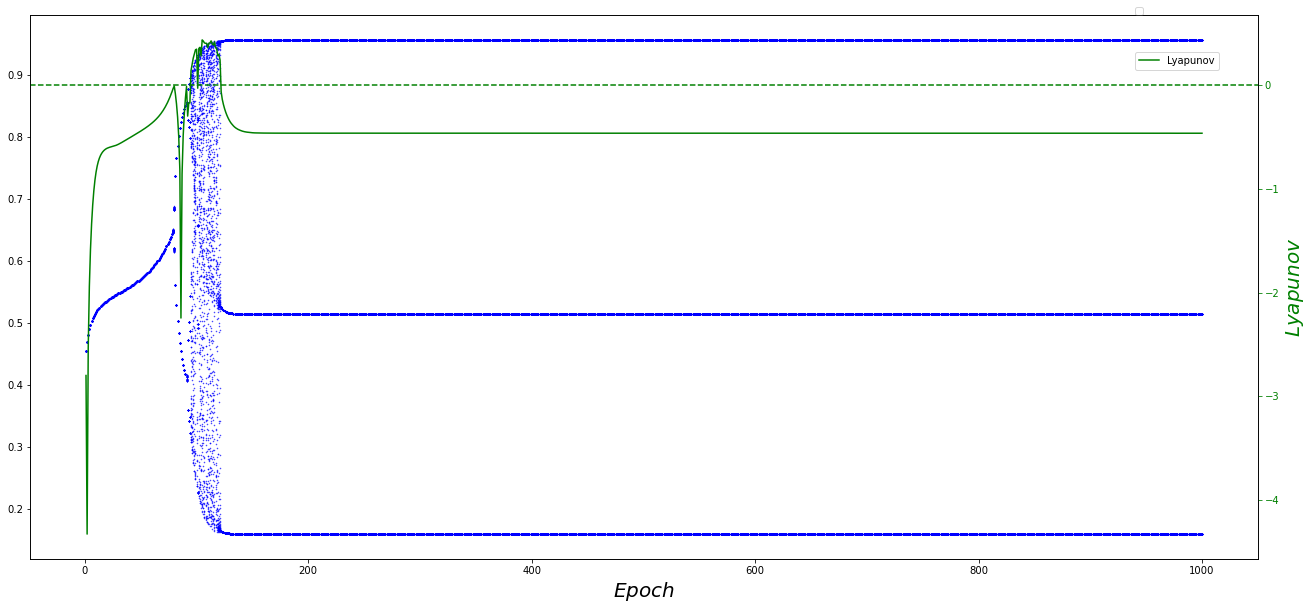

In [42]:
pet3=all_period[3]
lya3=all_lya[3]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet3,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya3,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

Text(0.5, -0.2, '(a)')

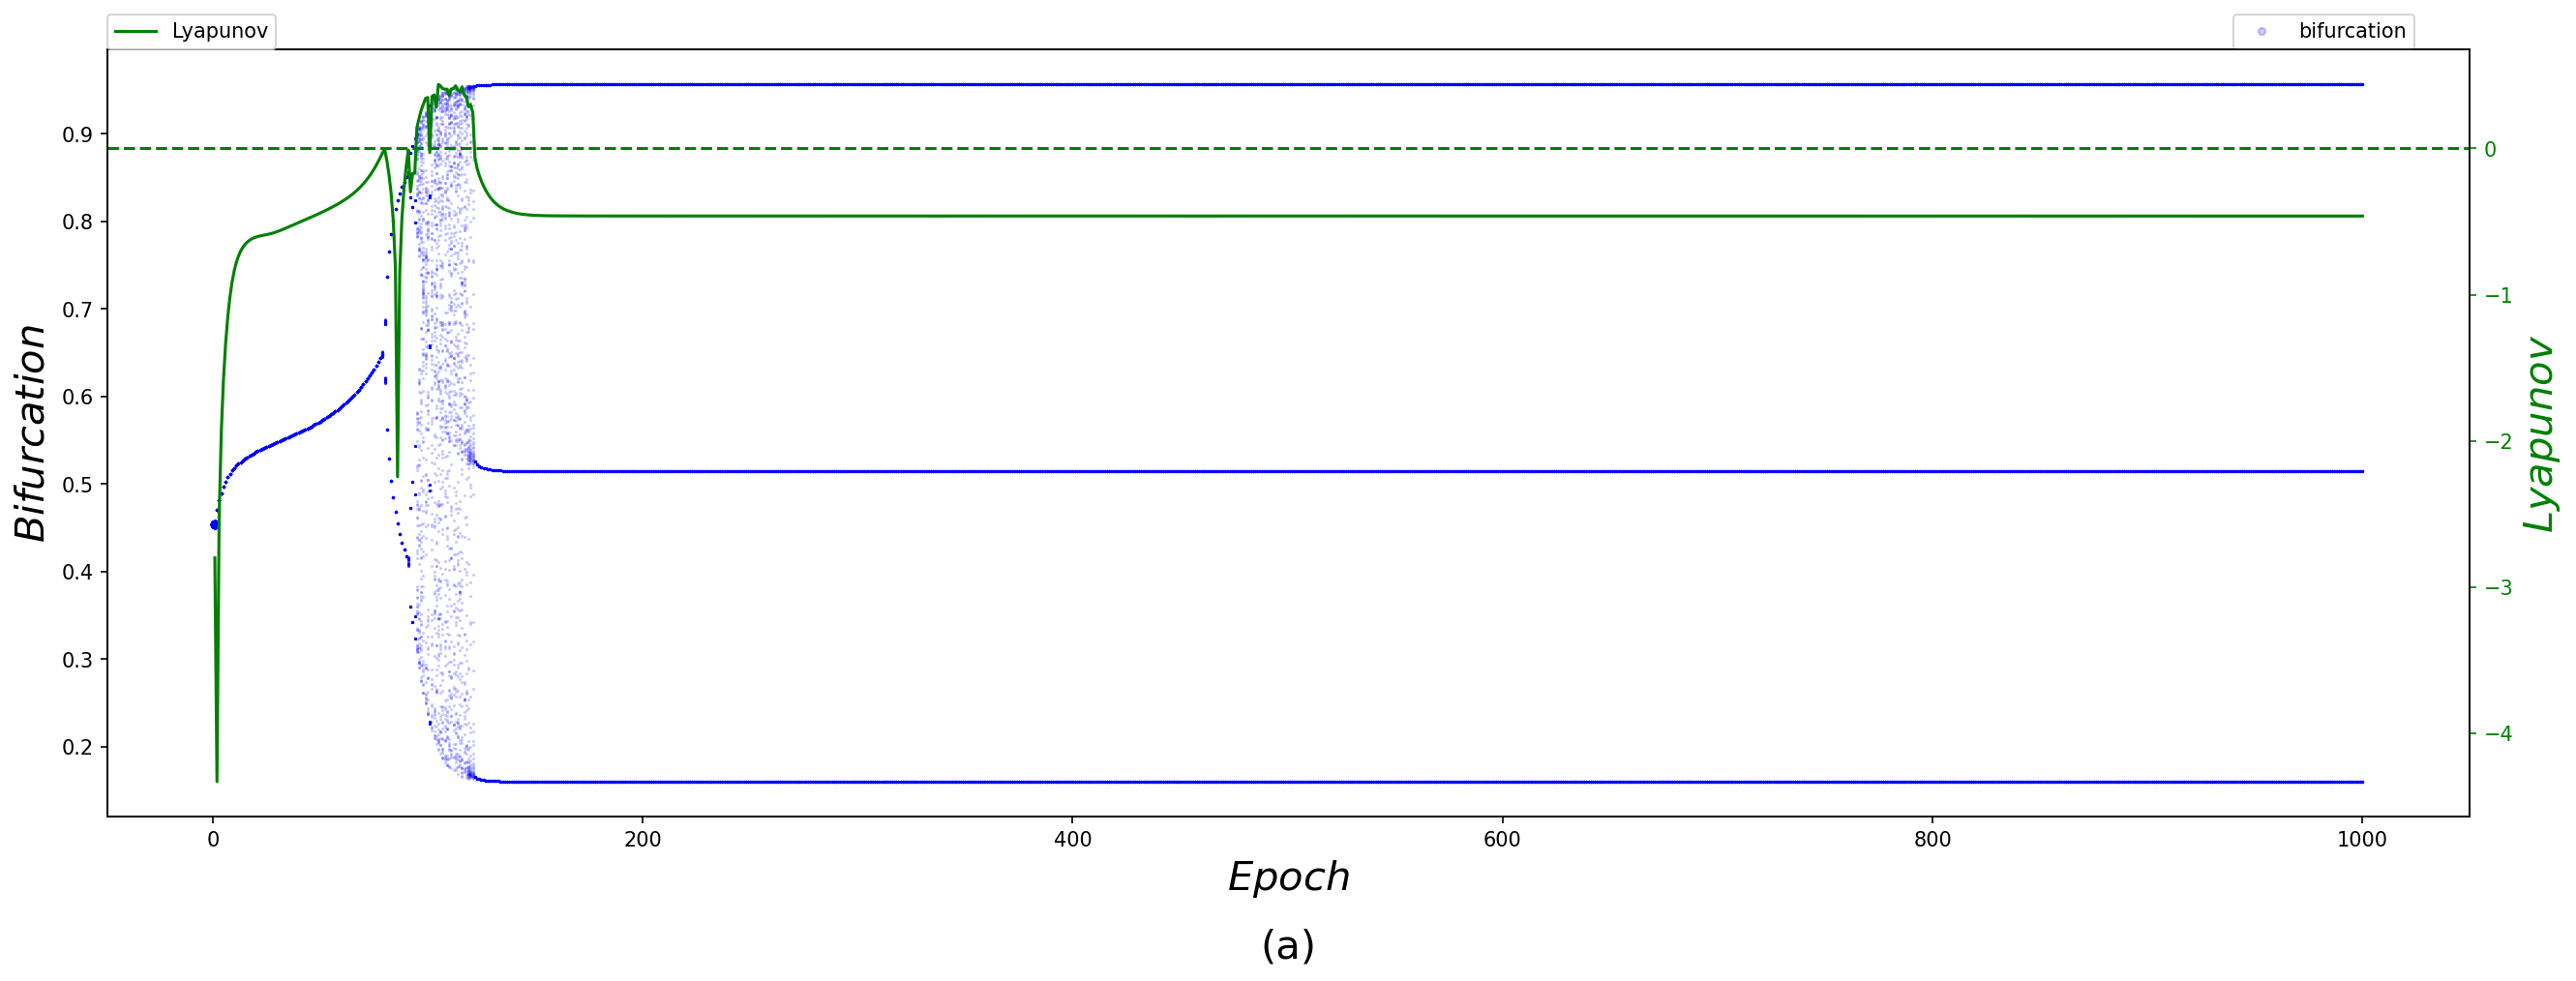

In [23]:
pet3=all_period[3]
lya3=all_lya[3]


fig,ax1=plt.subplots(figsize=(21, 7),dpi=150)
ax2=ax1.twinx()


ax1.plot(NN[0].detach().numpy(),pet3[0],'b.',alpha=0.2,markersize=7,label='bifurcation')
ax1.plot(NN.detach().numpy(),pet3,'b.',alpha=0.2,markersize=1)




ax2.plot(N.detach().numpy(),lya3,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0,1))

ax1.set_xlabel('$Epoch$',size=20)
ax1.set_ylabel('$Bifurcation$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')
plt.title('(a)',y=-0.2,size=20)

Text(0.5, -0.2, '(b)')

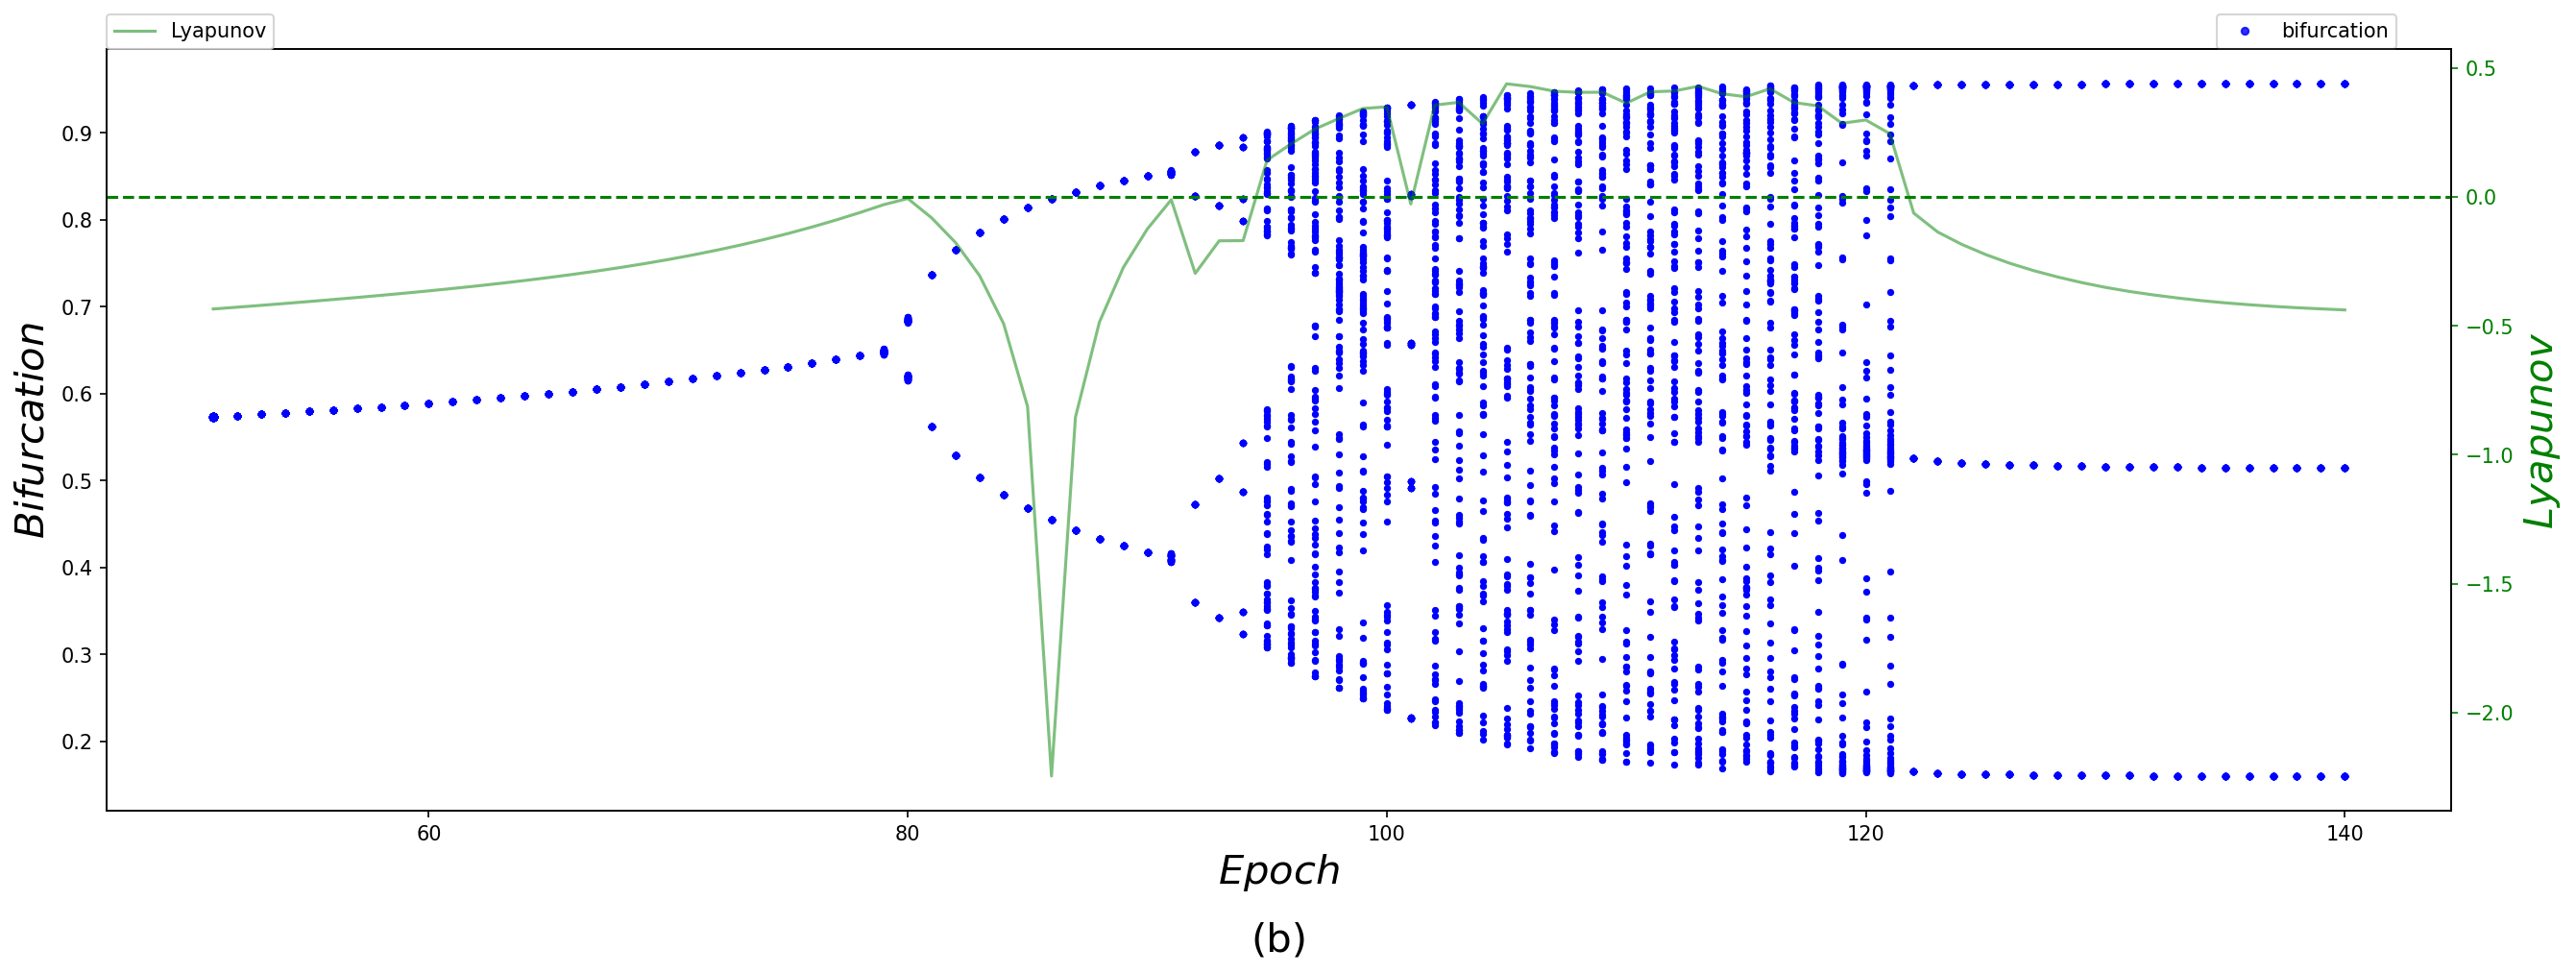

In [25]:
pet3=all_period[3]
lya3=all_lya[3]


fig,ax1=plt.subplots(figsize=(21, 7),dpi=150)
ax2=ax1.twinx()


ax1.plot(NN[50].detach().numpy(),pet3[50],'b.',alpha=0.8,markersize=7,label='bifurcation')
ax1.plot(NN[50:140].detach().numpy(),pet3[50:140],'b.',alpha=1,markersize=5)




ax2.plot(N[50:140].detach().numpy(),lya3[50:140],'green',alpha=0.5,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0,1))

ax1.set_xlabel('$Epoch$',size=20)
ax1.set_ylabel('$Bifurcation$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')
plt.title('(b)',y=-0.2,size=20)

No handles with labels found to put in legend.


Text(0.5, -0.2, '(c)')

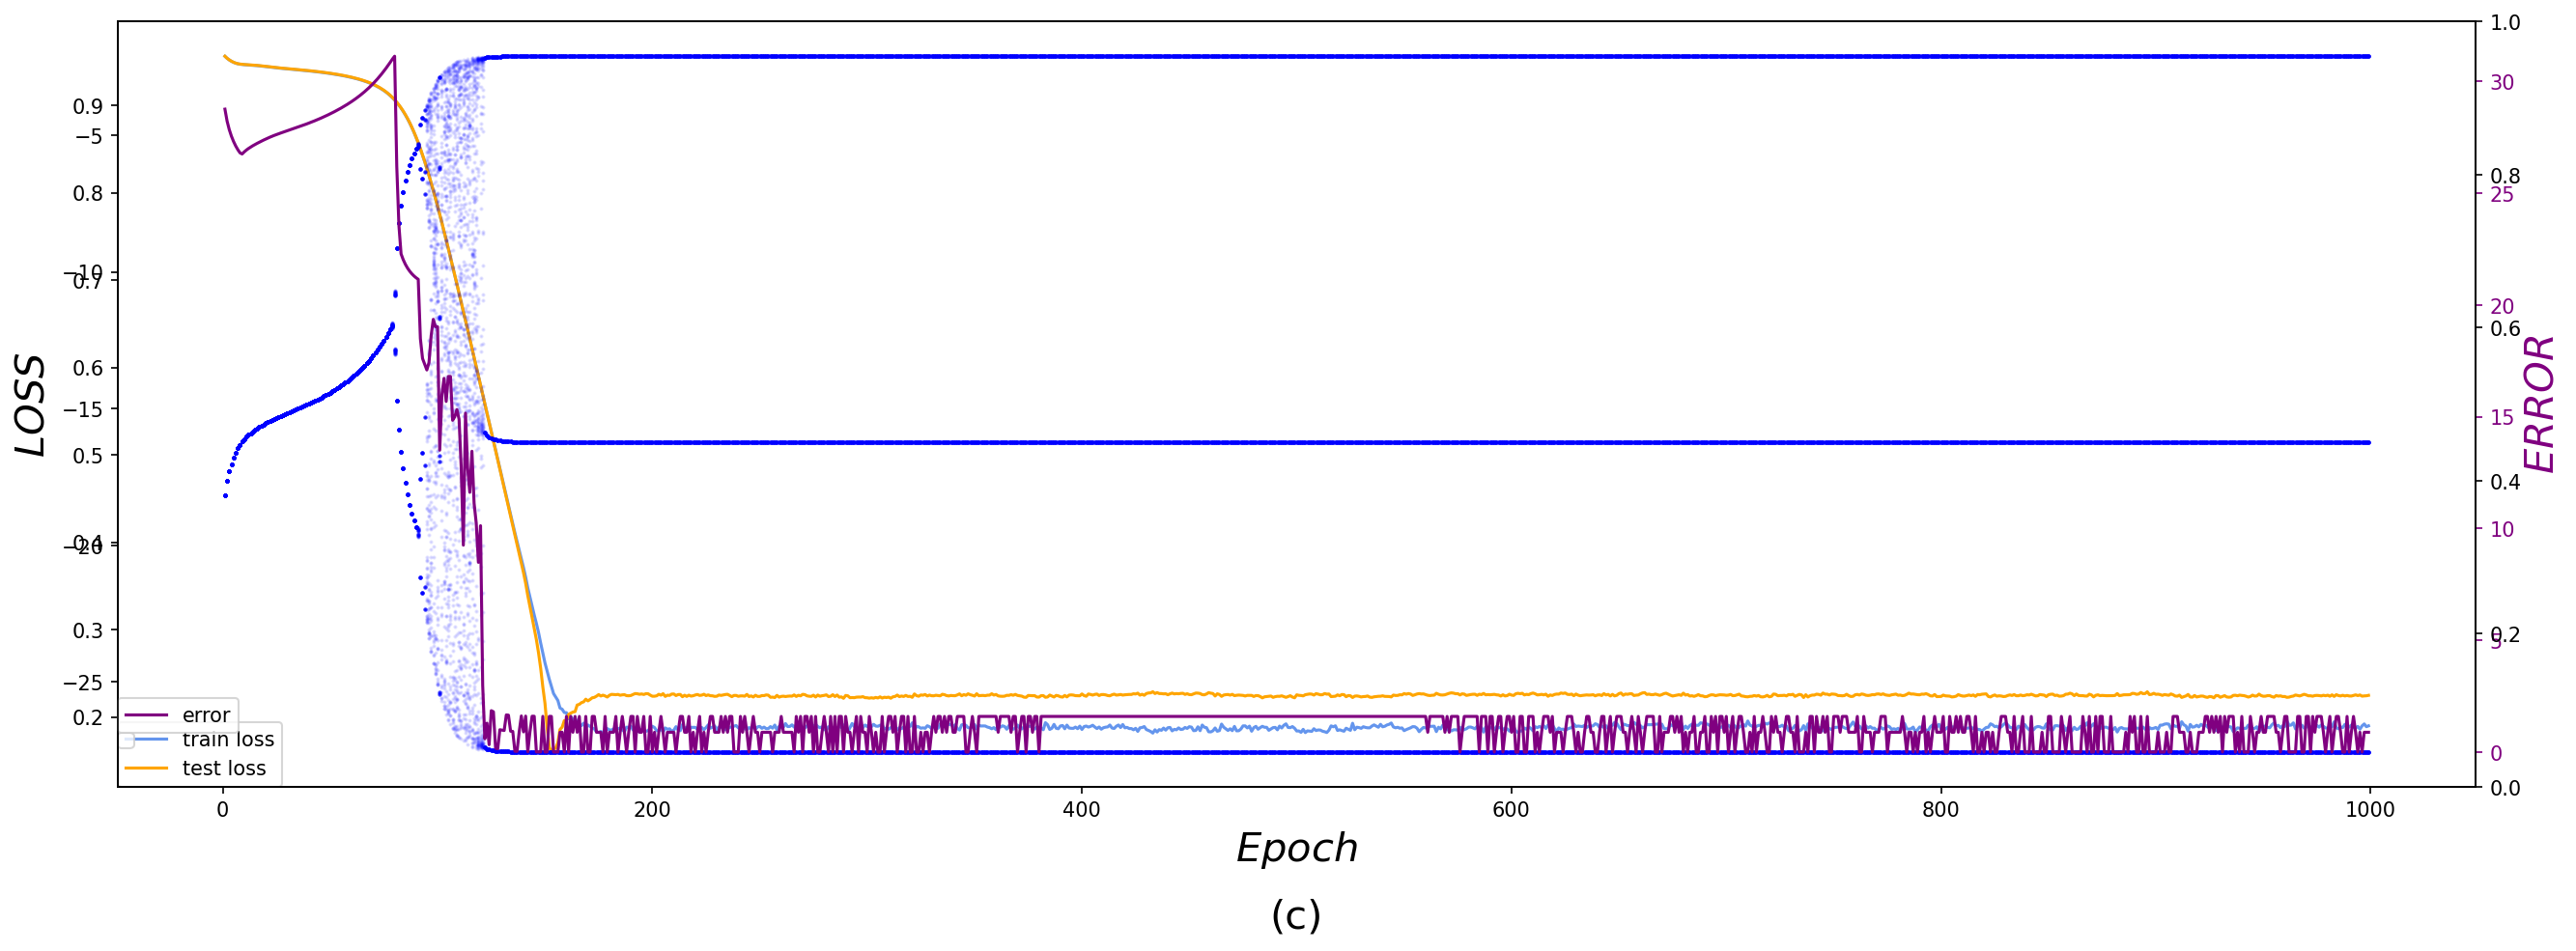

In [26]:
trl3=all_train_loss[3]
tel3=all_test_loss[3]
era3=all_error[3]
up_a=0
up_b=999


fig,ax1=plt.subplots(figsize=(21, 7),dpi=150)
ax2=ax1.twinx()

ax1.plot(N[up_a:up_b],np.log(trl3[up_a:up_b]),'cornflowerblue',label="train loss",alpha=1)    
ax1.plot(N[up_a:up_b],np.log(tel3[up_a:up_b]),'orange',label="test loss",alpha=1)

ax2.plot(NN[up_a:up_b,:],pet3[up_a:up_b,:],'b.',alpha=0.1,markersize=2)
#ax2.axhline(y=X0[0].detach().numpy(),linestyle='--',color='red',label='0.1599',alpha=0.5)
#ax2.axhline(y=X0[1].detach().numpy(),linestyle='--',color='red',label='0.5142',alpha=0.5)
#ax2.axhline(y=X0[2].detach().numpy(),linestyle='--',color='red',label='0.9563',alpha=0.5)
#ax2.tick_params(axis='y',colors='red')

ax3=ax1.twinx()
ax3.plot(N[up_a:up_b].detach().numpy(),era3[up_a:up_b],'purple',label="error",alpha=1)
#ax3.axvline(x=np.argmin(era)+1,linestyle='--',alpha=1)
ax3.tick_params(axis='y',colors='purple')

ax4=ax2.twinx()
#ax4.plot(N[up_a:up_b].detach().numpy(),lya0[up_a:up_b],'green',alpha=1,markersize=1,label='Lyapunov')
#ax4.axhline(y=0,color='green',linestyle='--')
#ax4.axvline(x=81,linestyle='--',alpha=1,color='green')
#ax4.tick_params(axis='y',colors='green')


ax1.legend(loc=(0,0))
ax2.legend(loc=(0,0.05))
ax3.legend(loc=(0,0.07))
#ax4.legend(loc=(0,0.154))

ax1.set_xlabel('$Epoch$',size=20)
ax1.set_ylabel('$LOSS$',size=20)
#ax2.set_ylabel('$Period-3$',size=20,color='red',loc='bottom')
ax3.set_ylabel('$ERROR$',size=20,color='purple',loc='center')
#ax4.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')
plt.title('(c)',y=-0.2,size=20)

Text(0.5, -0.2, '(b)')

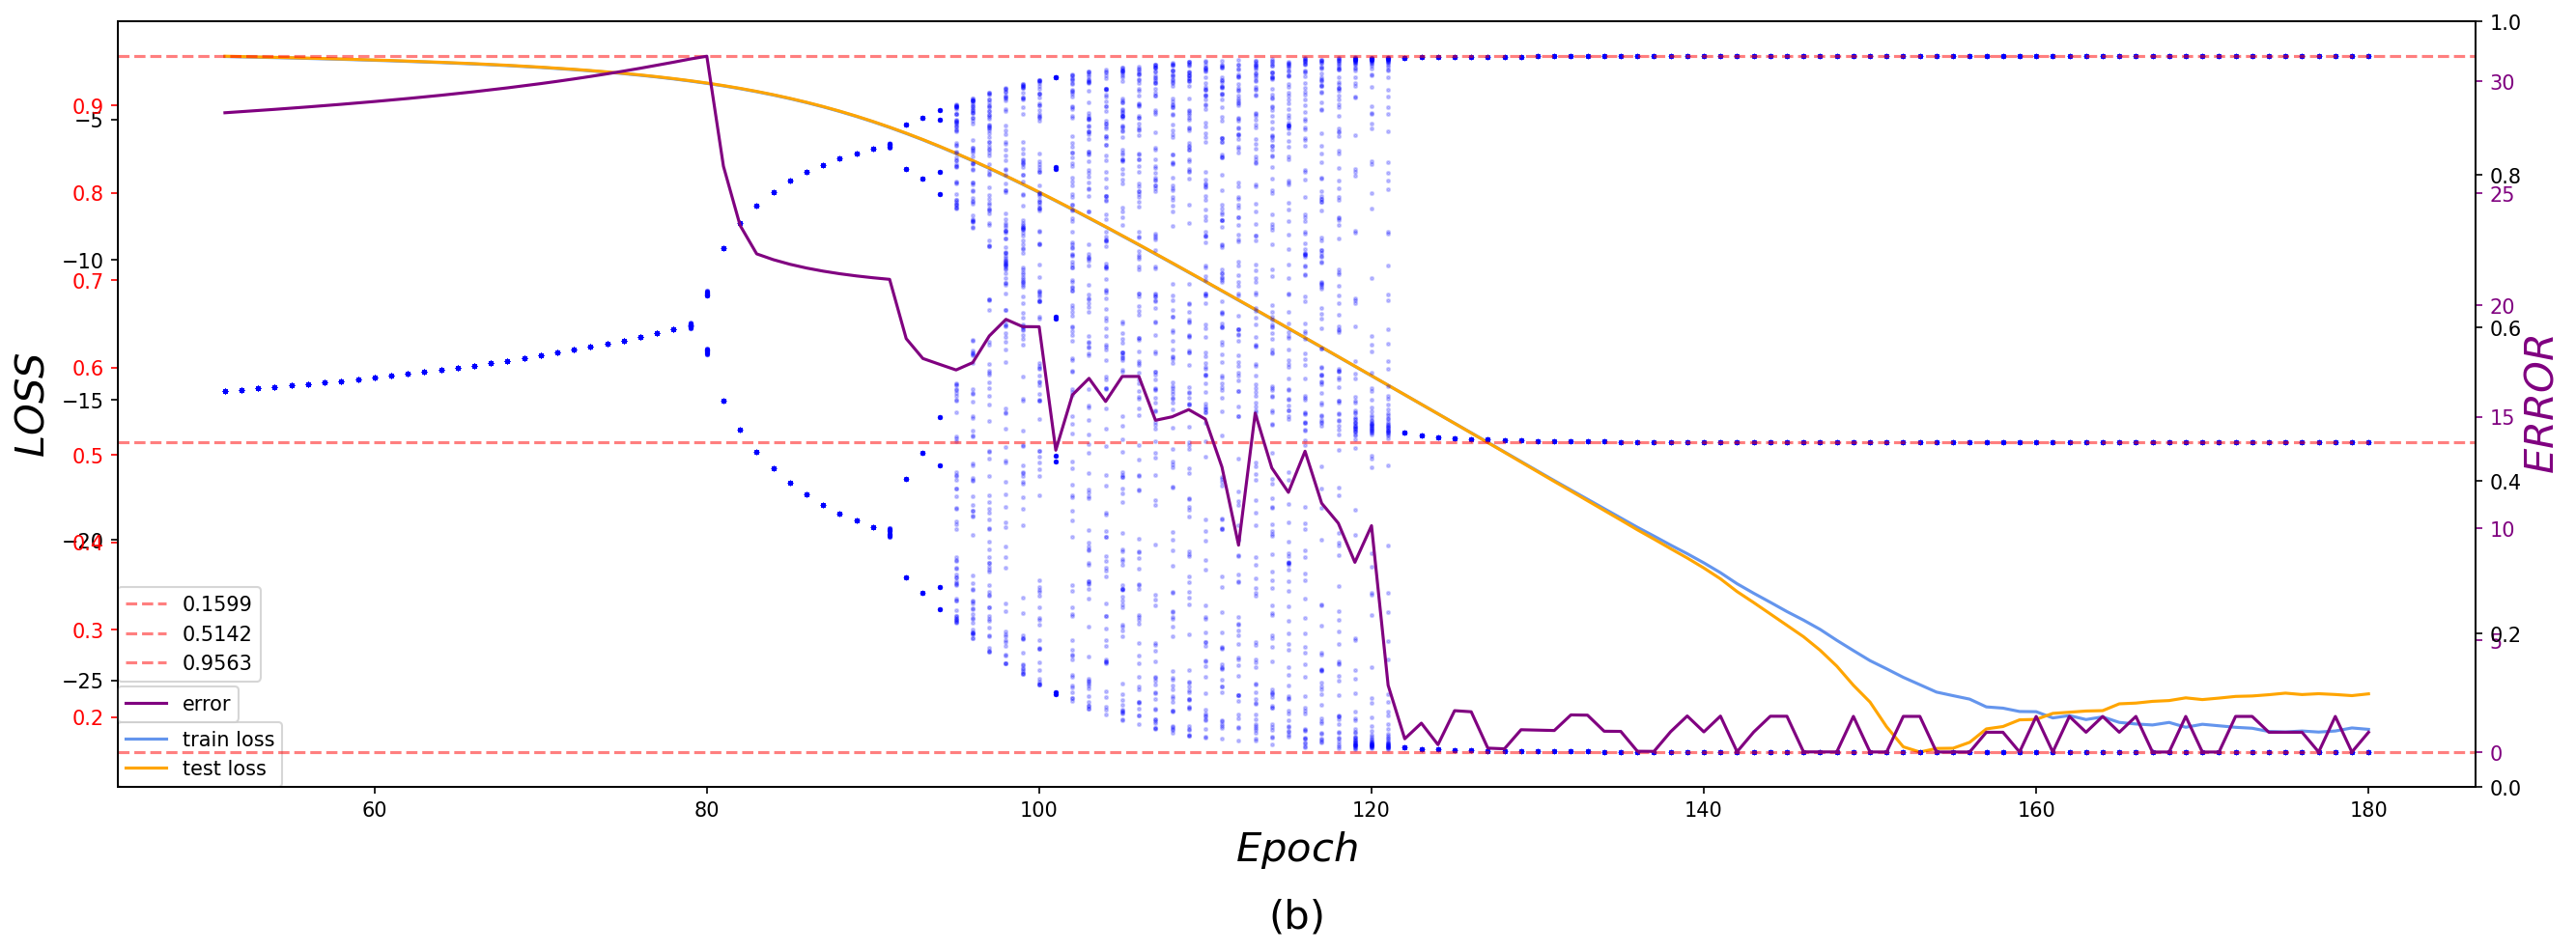

In [60]:
trl3=all_train_loss[3]
tel3=all_test_loss[3]
era3=all_error[3]
up_a=50
up_b=180


fig,ax1=plt.subplots(figsize=(21, 7),dpi=150)
ax2=ax1.twinx()

ax1.plot(N[up_a:up_b],np.log(trl3[up_a:up_b]),'cornflowerblue',label="train loss",alpha=1)    
ax1.plot(N[up_a:up_b],np.log(tel3[up_a:up_b]),'orange',label="test loss",alpha=1)

ax2.plot(NN[up_a:up_b,:],pet3[up_a:up_b,:],'b.',alpha=0.2,markersize=3)

ax2.axhline(y=X0[0].detach().numpy(),linestyle='--',color='red',label='0.1599',alpha=0.5)
ax2.axhline(y=X0[1].detach().numpy(),linestyle='--',color='red',label='0.5142',alpha=0.5)
ax2.axhline(y=X0[2].detach().numpy(),linestyle='--',color='red',label='0.9563',alpha=0.5)
ax2.tick_params(axis='y',colors='red')

ax3=ax1.twinx()
ax3.plot(N[up_a:up_b].detach().numpy(),era3[up_a:up_b],'purple',label="error",alpha=1)
#ax3.axvline(x=np.argmin(era)+1,linestyle='--',alpha=1)
ax3.tick_params(axis='y',colors='purple')

ax4=ax2.twinx()
#ax4.plot(N[up_a:up_b].detach().numpy(),lya0[up_a:up_b],'green',alpha=1,markersize=1,label='Lyapunov')
#ax4.axhline(y=0,color='green',linestyle='--')
#ax4.axvline(x=81,linestyle='--',alpha=1,color='green')
#ax4.tick_params(axis='y',colors='green')


ax1.legend(loc=(0,0))
ax5.legend(loc=(0,0.13))
ax3.legend(loc=(0,0.085))
ax2.legend(loc=(0,0.138))

ax1.set_xlabel('$Epoch$',size=20)
ax1.set_ylabel('$LOSS$',size=20)
#ax2.set_ylabel('$Period-3$',size=20,color='red',loc='bottom')
ax3.set_ylabel('$ERROR$',size=20,color='purple',loc='center')
plt.title('(b)',y=-0.2,size=20)



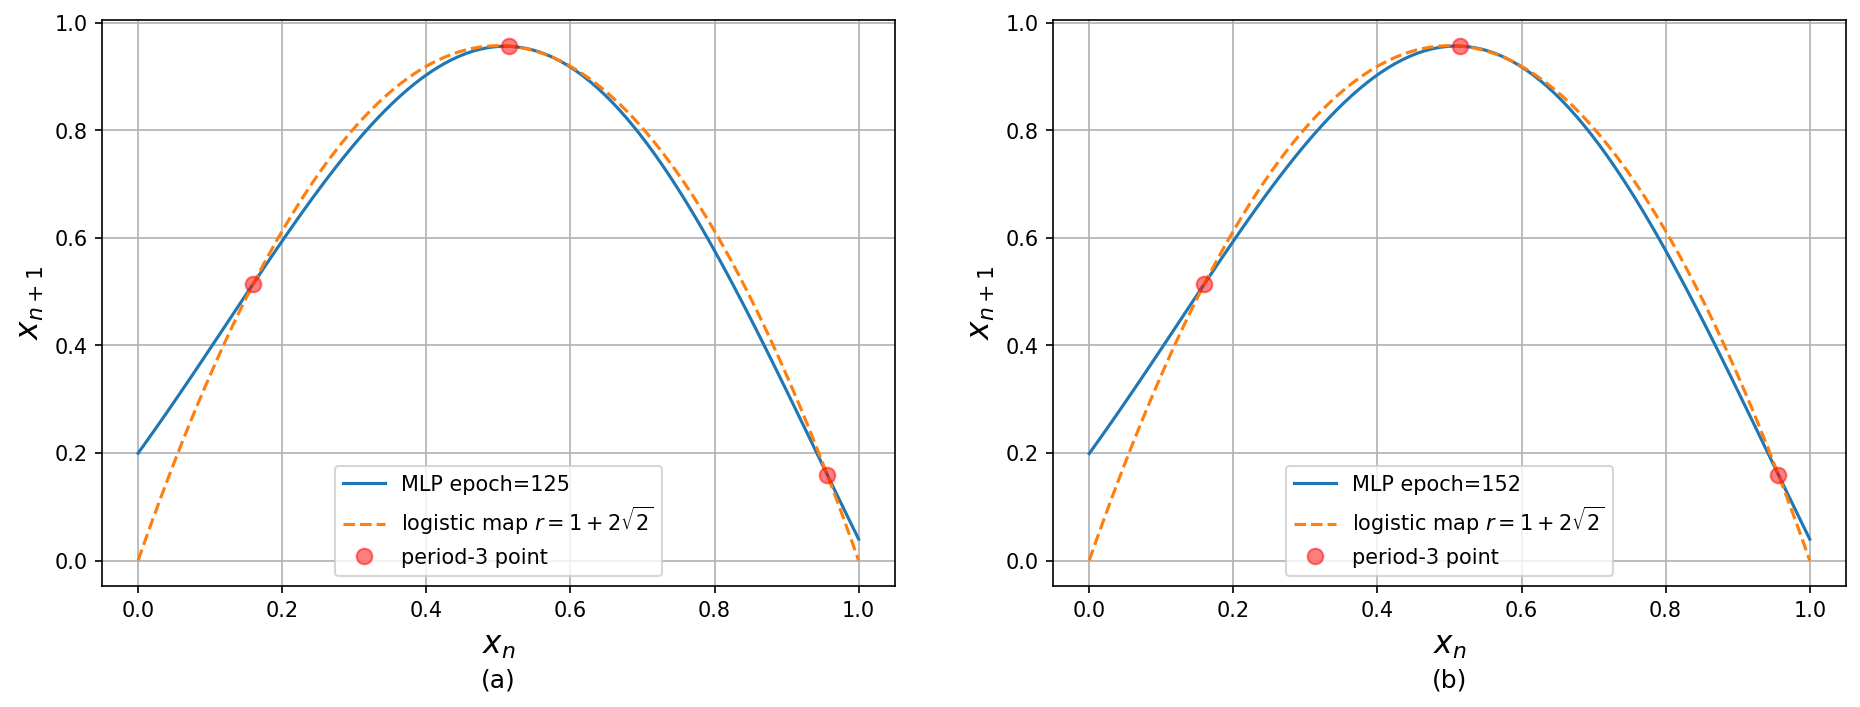

In [33]:
def LogisticMapFunction(x,r): # 定义 logistic map
    return r*x*(1-x)



plt.figure(figsize=(15,5),dpi=150)
plt.subplot(121)
xx=np.linspace(0,1,100)
yy0=all_ym[3,125]
yy=LogisticMapFunction(xx,1+2*np.sqrt(2))
plt.plot(xx,yy0,label='MLP epoch=125')
plt.plot(xx,yy,'--',label='logistic map $r=1+2\sqrt{2}$')

plt.plot(X0[0],X0[1],'r.',markersize=15,alpha=0.5,label='period-3 point')
plt.plot(X0[1],X0[2],'r.',markersize=15,alpha=0.5)
plt.plot(X0[2],X0[3],'r.',markersize=15,alpha=0.5)
plt.xlabel('$x_n$',size=15)
plt.ylabel('$x_{n+1}$',size=15)
plt.legend(loc=0)
plt.title('(a)',y=-0.2)
plt.grid(True)

plt.subplot(122)
xx=np.linspace(0,1,100)
yy01=all_ym[3,152]
yy=LogisticMapFunction(xx,1+2*np.sqrt(2))
plt.plot(xx,yy01,label='MLP epoch=152')
plt.plot(xx,yy,'--',label='logistic map $r=1+2\sqrt{2}$')

plt.plot(X0[0],X0[1],'r.',markersize=15,alpha=0.5,label='period-3 point')
plt.plot(X0[1],X0[2],'r.',markersize=15,alpha=0.5)
plt.plot(X0[2],X0[3],'r.',markersize=15,alpha=0.5)
plt.xlabel('$x_n$',size=15)
plt.ylabel('$x_{n+1}$',size=15)
plt.legend(loc=0)
plt.title('(b)',y=-0.2)
plt.grid(True)

## Net5 a=2.5

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

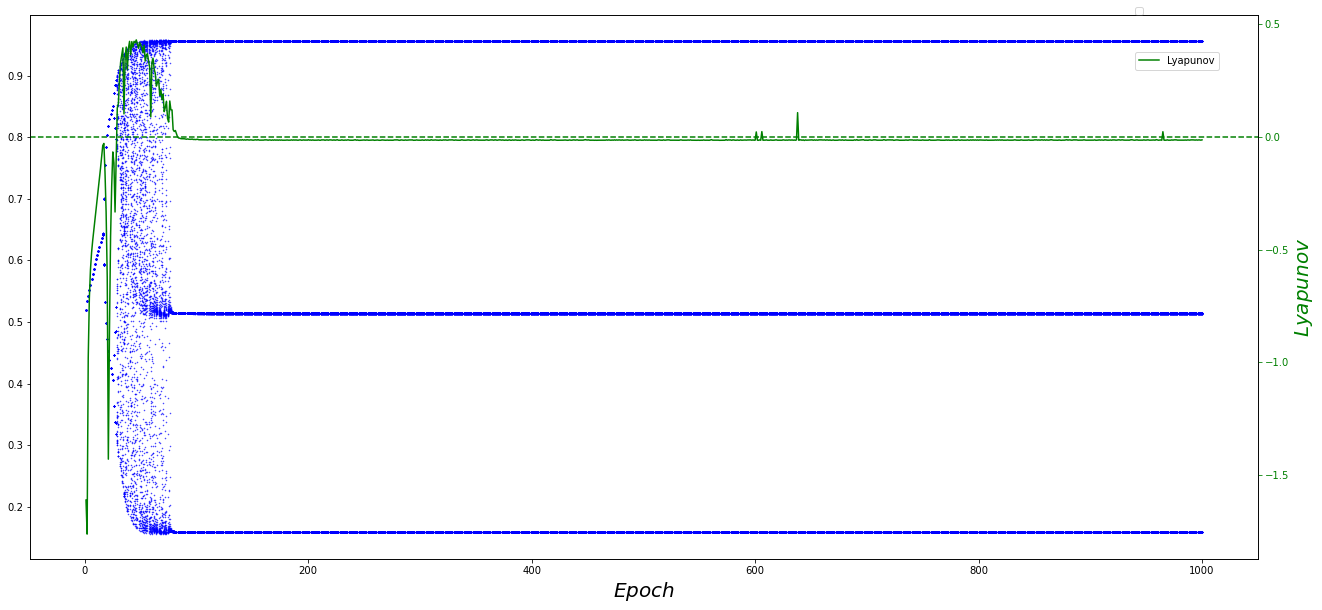

In [43]:
pet4=all_period[4]
lya4=all_lya[4]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet4,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya4,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

## Net6 a=3.0

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

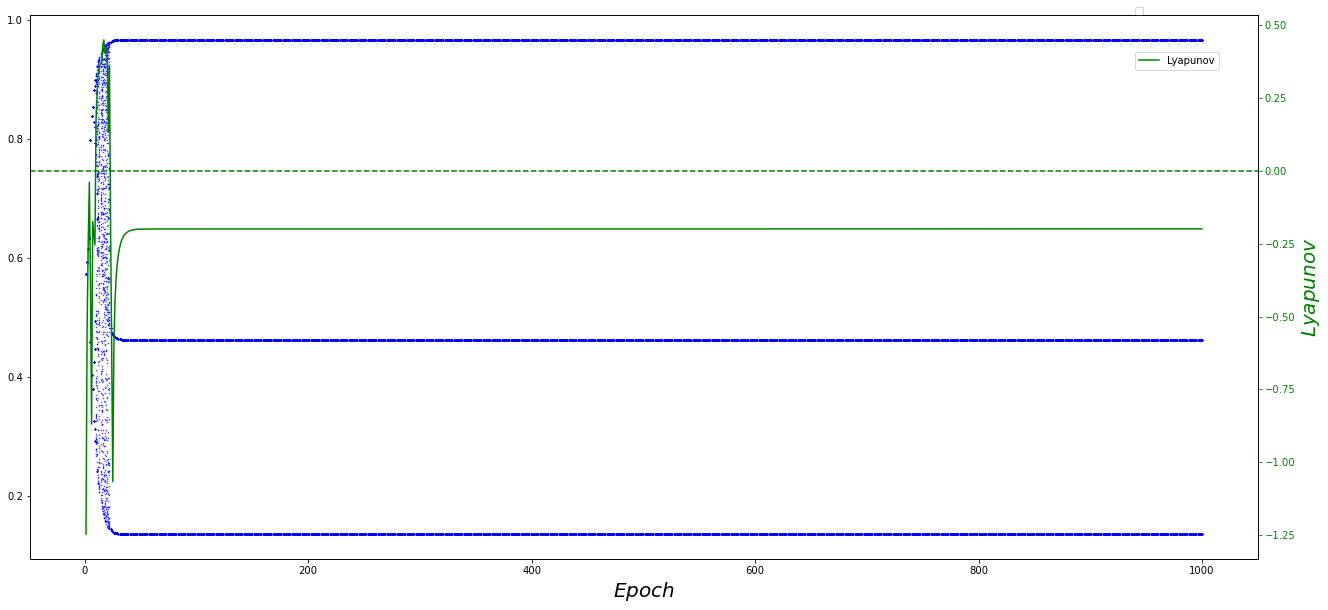

In [44]:
pet5=all_period[5]
lya5=all_lya[5]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet5,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya5,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

## Net7 a=3.5

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

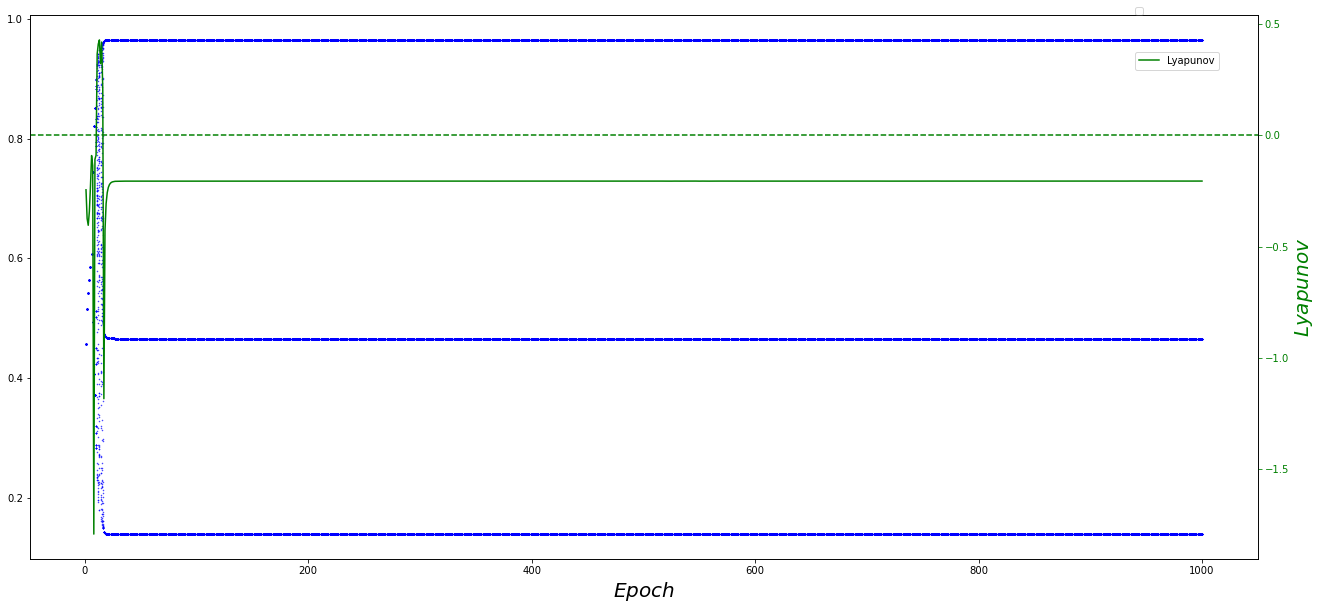

In [45]:
pet6=all_period[6]
lya6=all_lya[6]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet6,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya6,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

## Net8 a=4.0

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

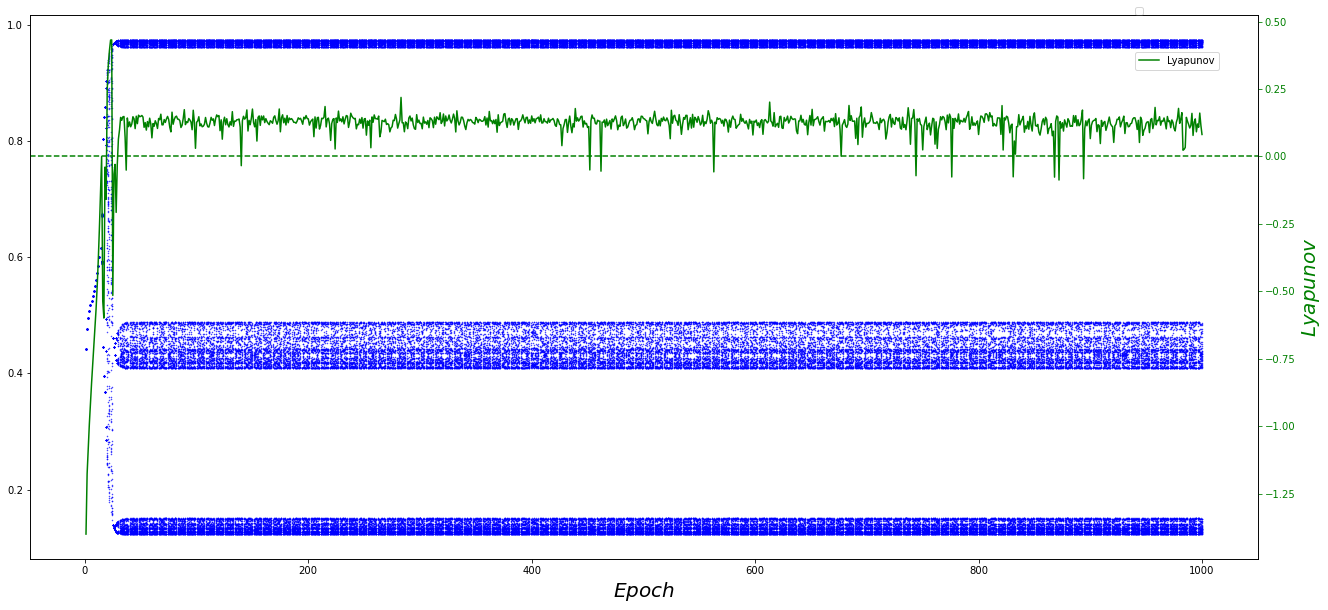

In [46]:
pet7=all_period[7]
lya7=all_lya[7]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet7,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya7,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

## Net9 a=4.5

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

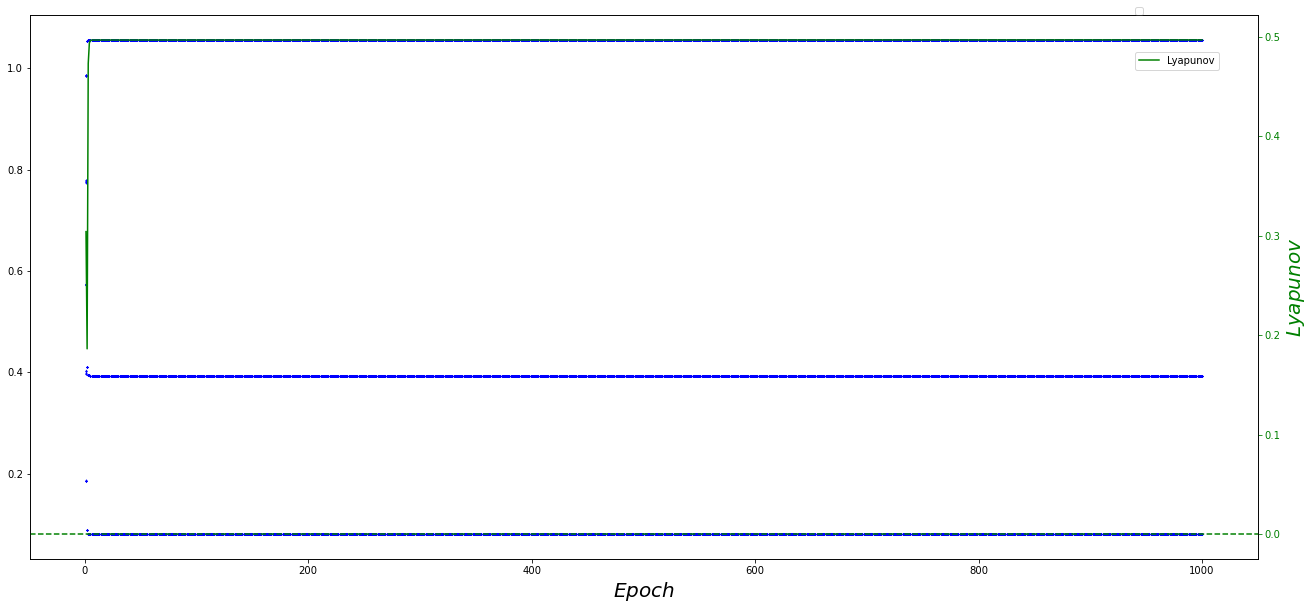

In [47]:
pet8=all_period[8]
lya8=all_lya[8]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet8,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya8,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

## Net10 a=5.0

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

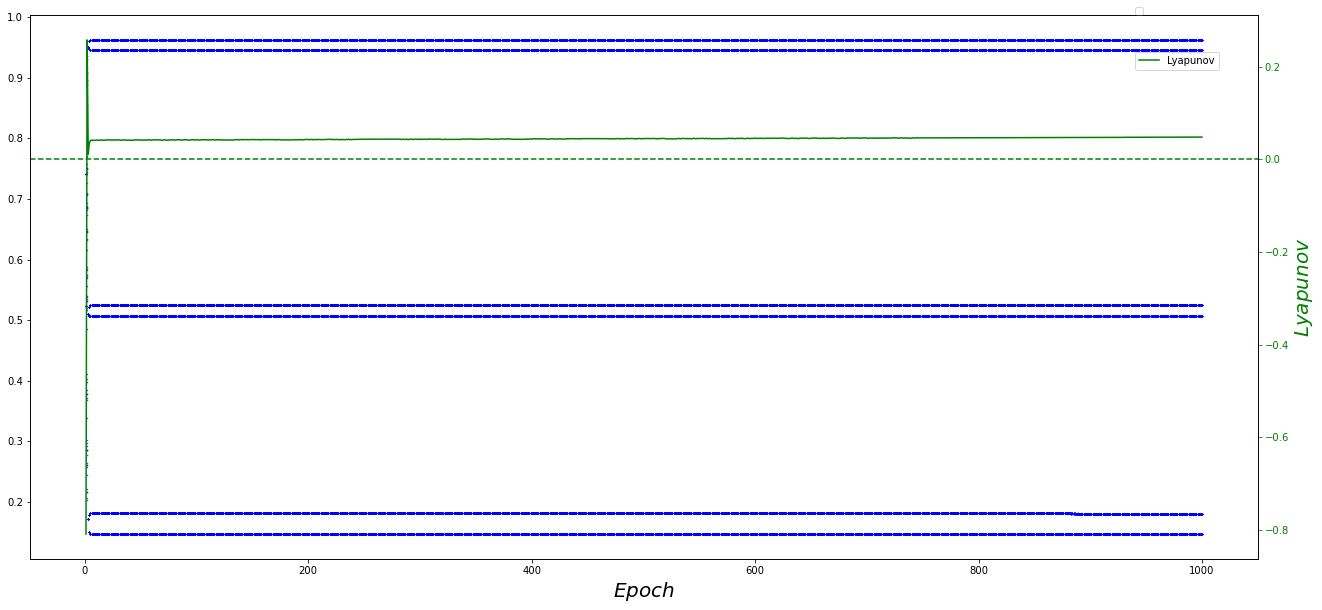

In [48]:
pet9=all_period[9]
lya9=all_lya[9]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet9,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya9,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

## Net11 a=5.5

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

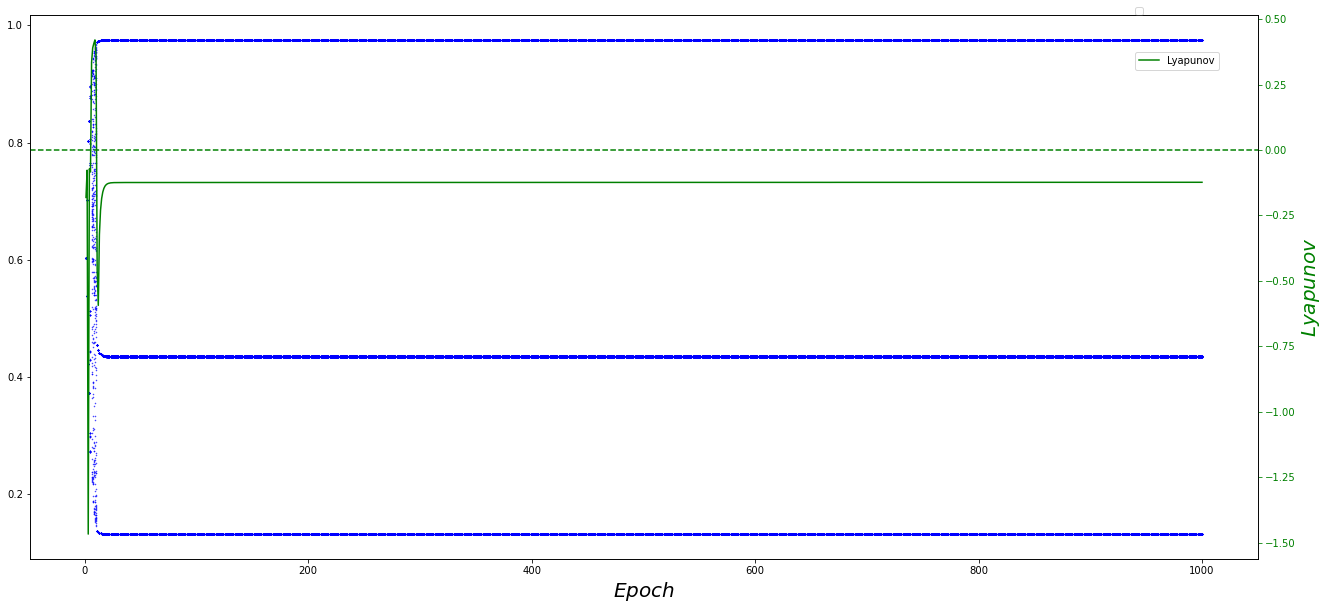

In [49]:
pet10=all_period[10]
lya10=all_lya[10]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet10,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya10,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

## Net12 a=6.0

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

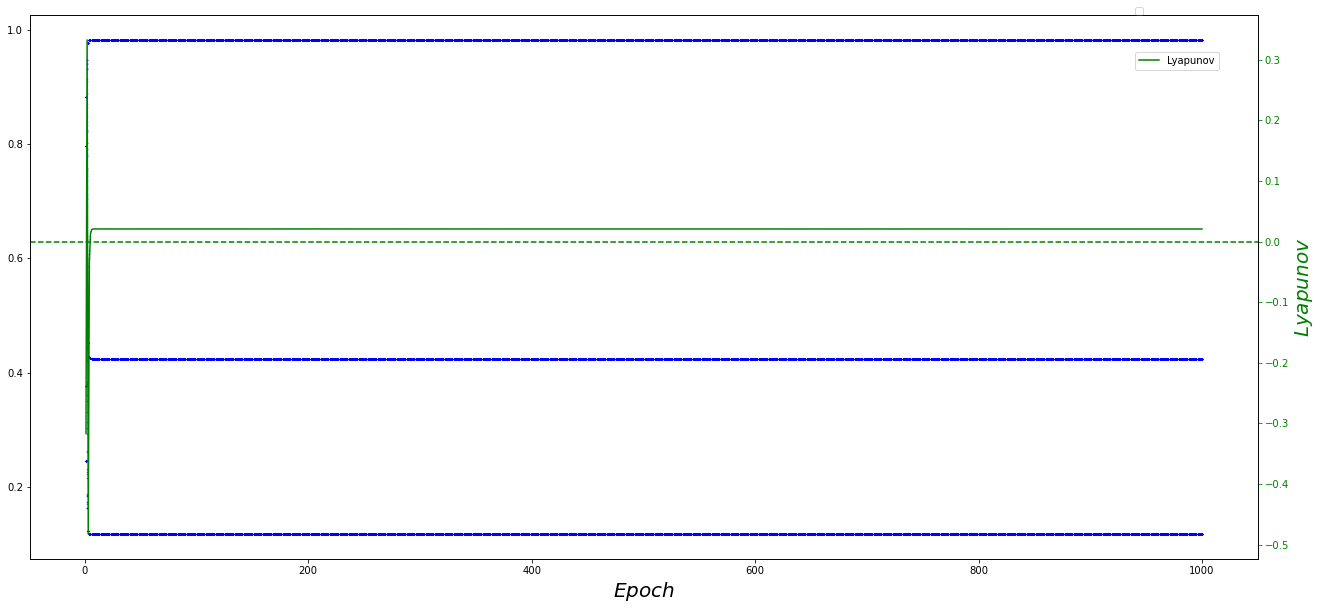

In [50]:
pet11=all_period[11]
lya11=all_lya[11]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet11,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya11,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

## Net13 a=6.5

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

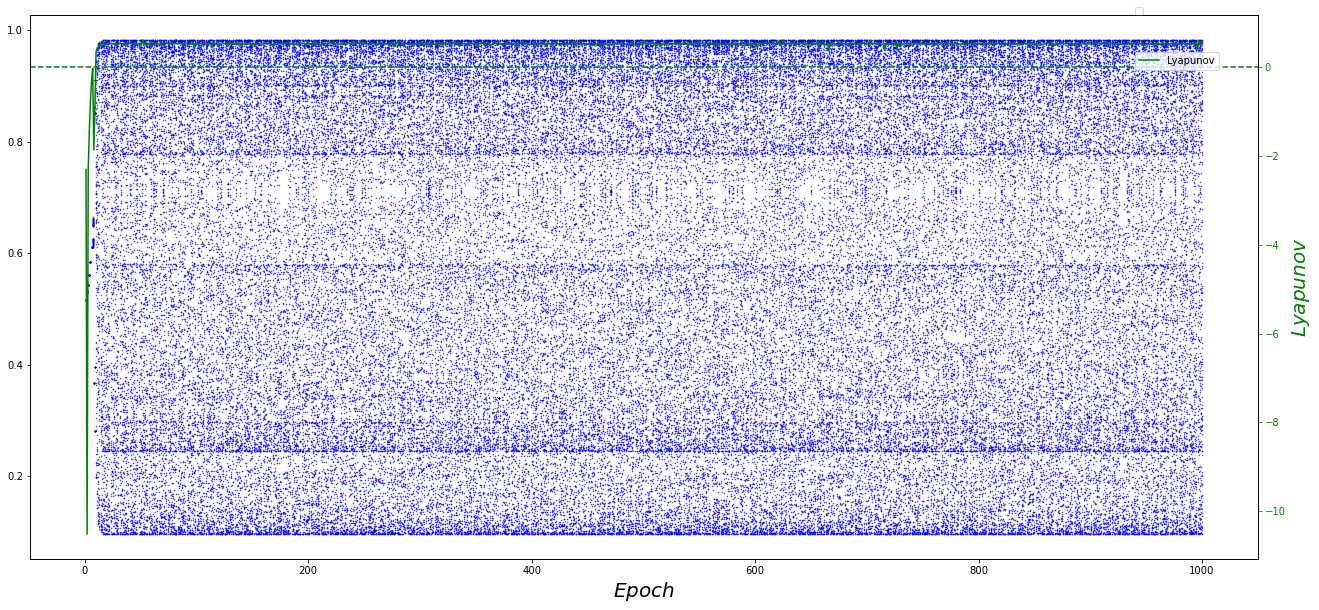

In [65]:
pet12=all_period[12]
lya12=all_lya[12]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet12,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya12,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

## Net14 a=7.0

No handles with labels found to put in legend.


Text(0, 0.5, '$Lyapunov$')

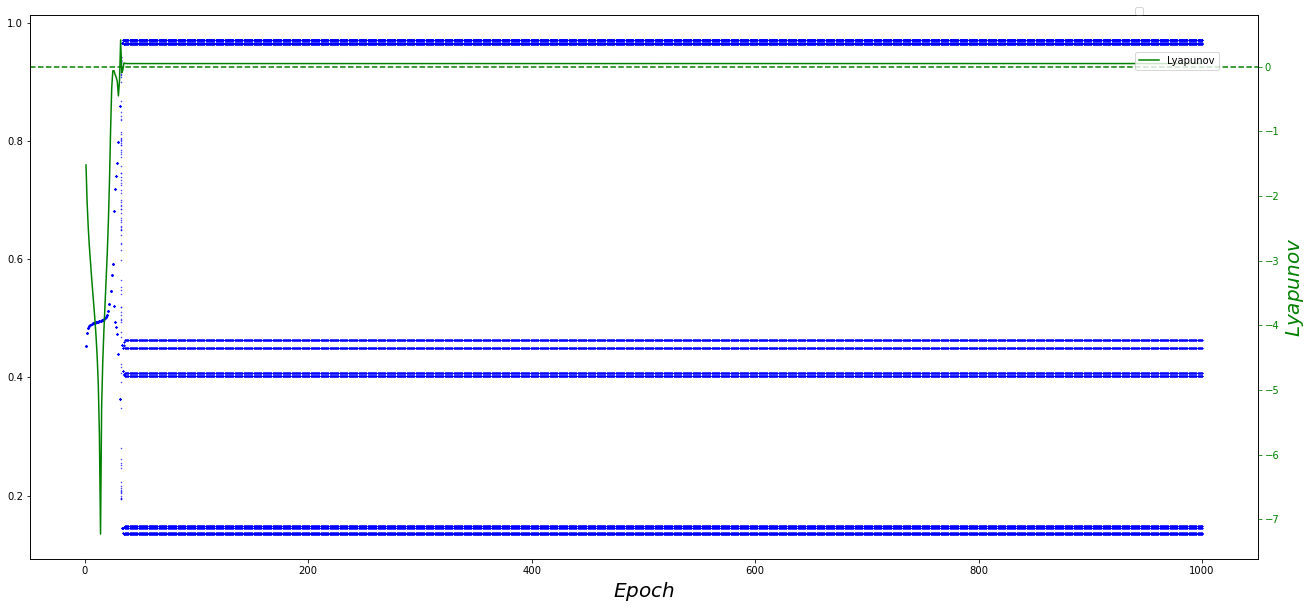

In [52]:
pet13=all_period[13]
lya13=all_lya[13]


fig,ax1=plt.subplots(figsize=(22, 10))
ax2=ax1.twinx()



ax1.plot(NN.detach().numpy(),pet13,'b.',alpha=0.8,markersize=1)




ax2.plot(N.detach().numpy(),lya13,'green',alpha=1,markersize=1,label='Lyapunov')
ax2.axhline(y=0,color='green',linestyle='--')
ax2.tick_params(axis='y',colors='green')


ax1.legend(loc=(0.9,1))
ax2.legend(loc=(0.9,0.90))

ax1.set_xlabel('$Epoch$',size=20)

ax2.set_ylabel('$Lyapunov$',size=20,color='green',loc='center')

# fig

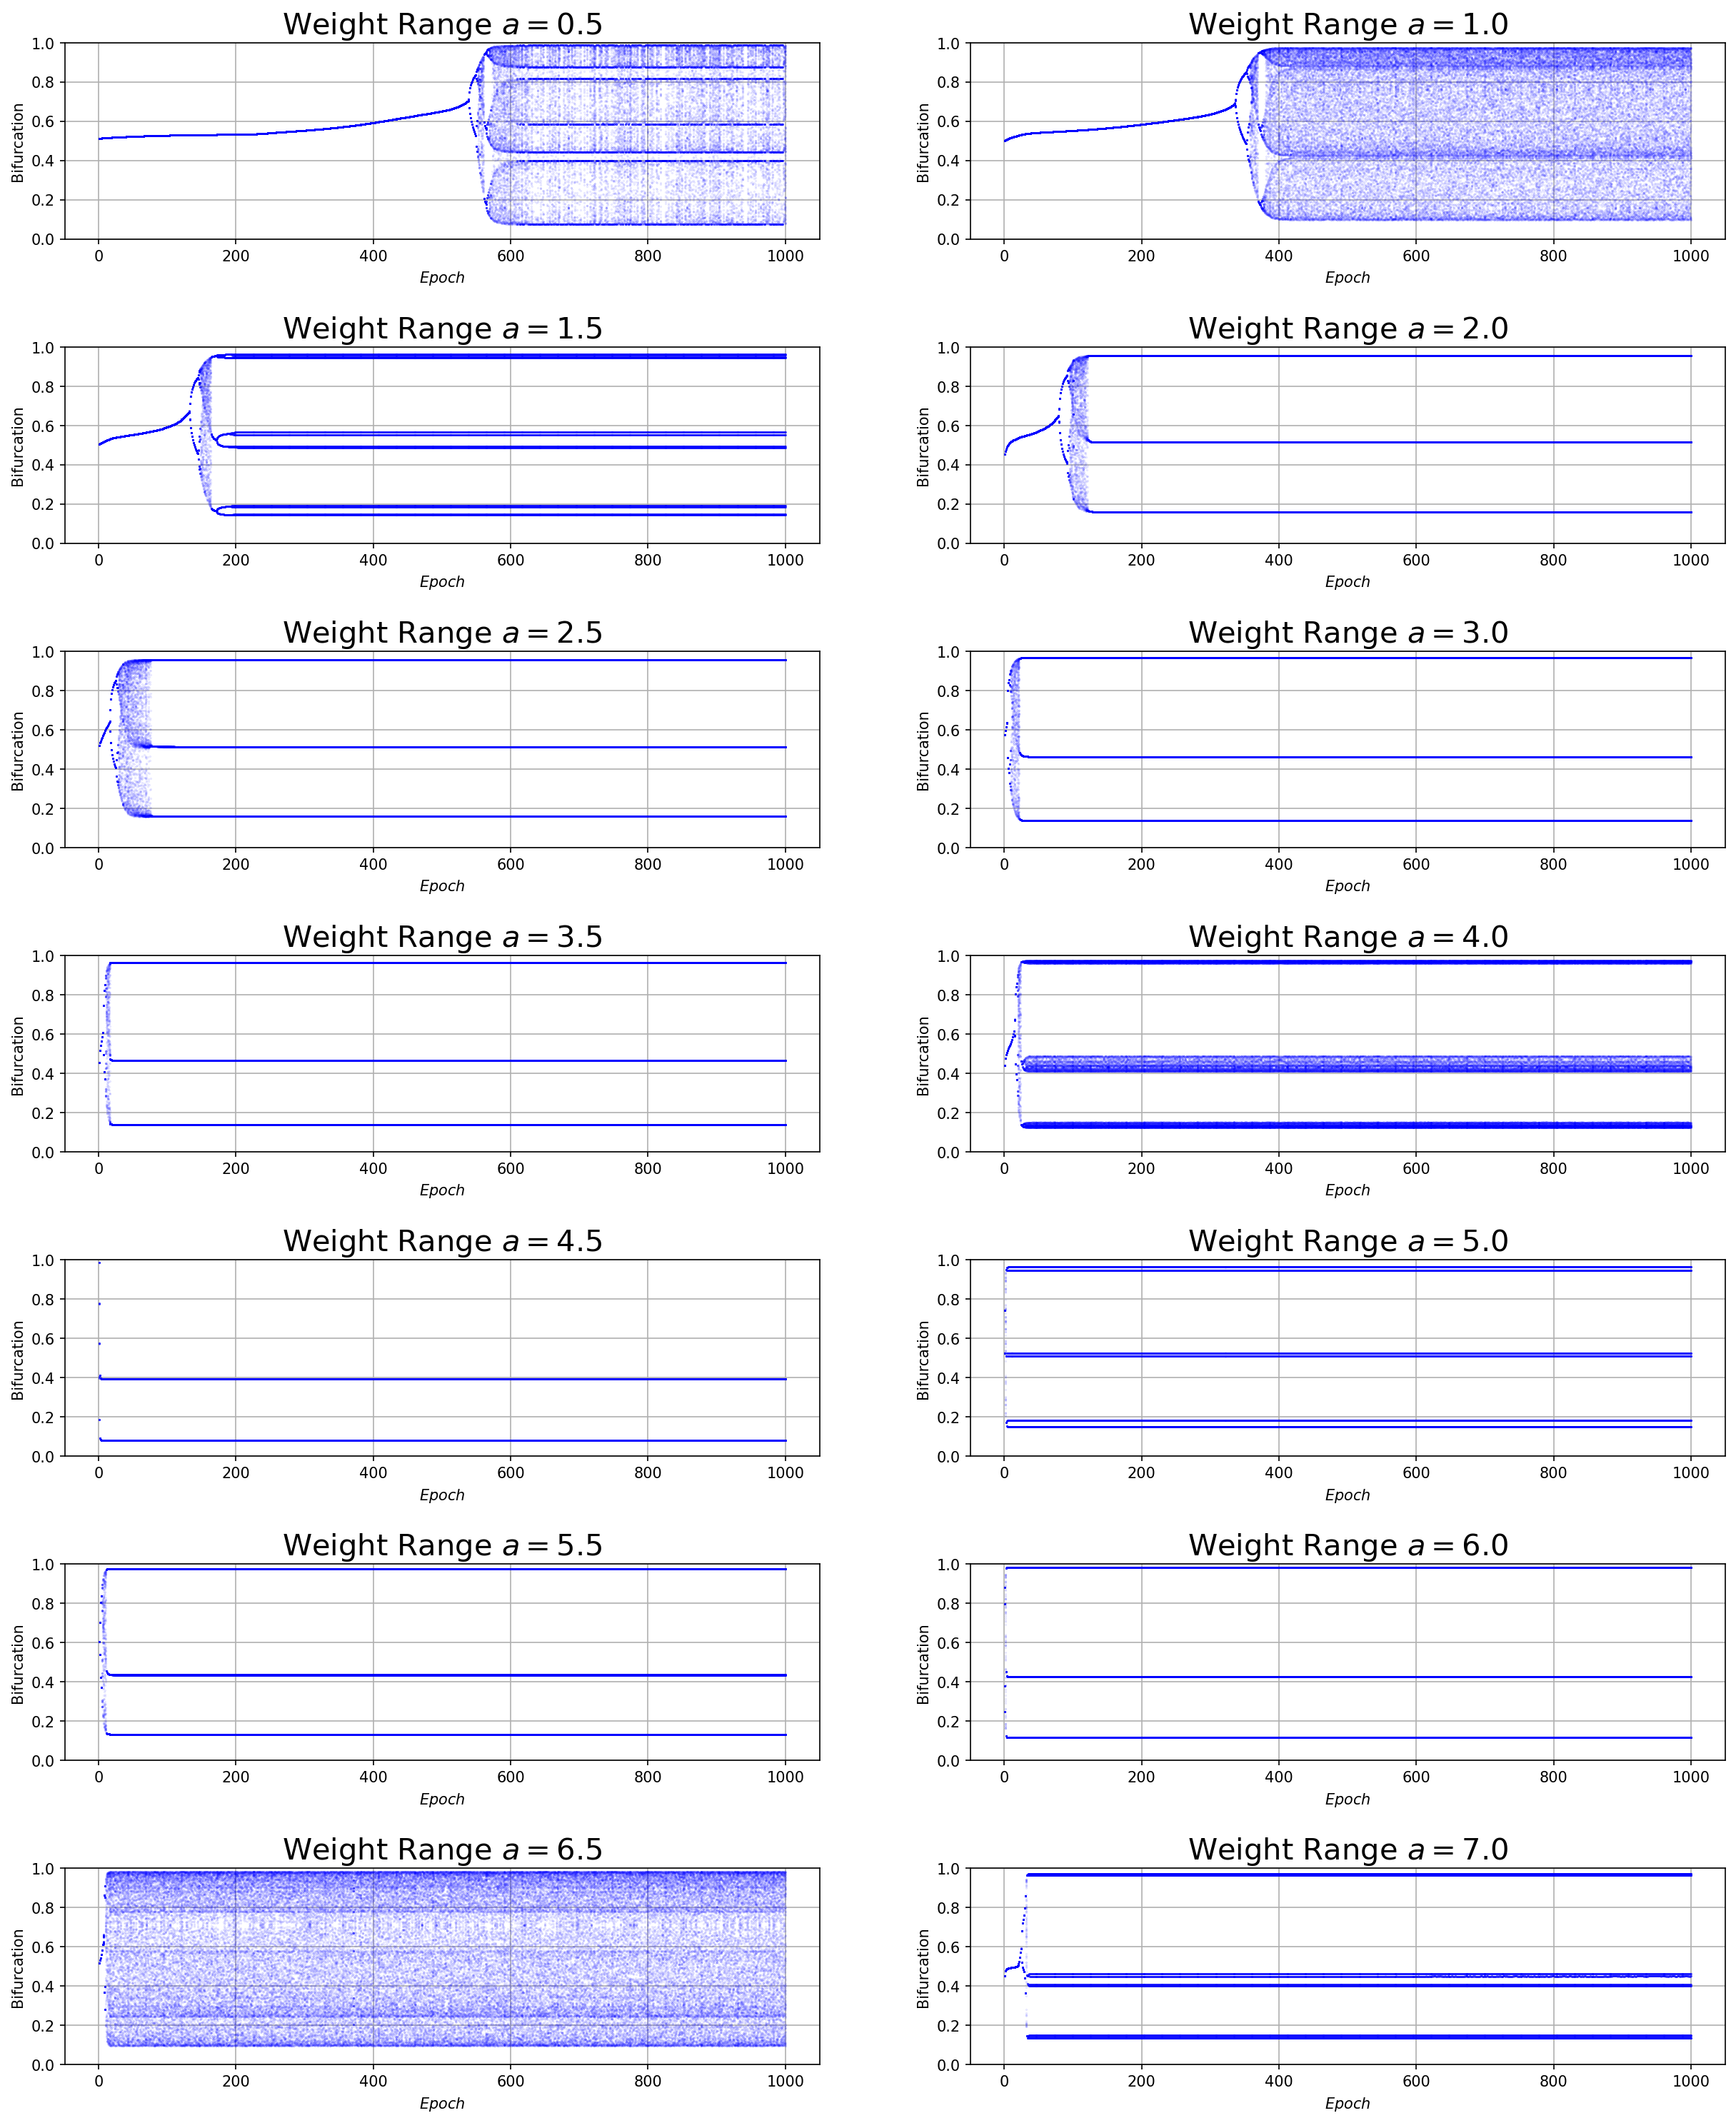

In [22]:
paramtar=np.array(['a=0.5','a=1.0','a=1.5','a=2.0','a=2.5','a=3.0','a=3.5','a=4.0','a=4.5','a=5.0','a=5.5','a=6.0','a=6.5','a=7.0'])
plt.figure(figsize=(20,25),dpi=150)
for i in np.arange(14):
    plt.subplot(7,2,i+1)
    plt.subplots_adjust(hspace=0.55)
    plt.ylim(0,1)
    plt.title('Weight Range $%s$'%paramtar[i],size=20)
    plt.xlabel('$Epoch$')
    plt.ylabel('Bifurcation')
    plt.plot(NN.detach().numpy(),all_period[i],'b.',markersize=0.5,alpha=0.2)
    plt.grid(True)

# fig2

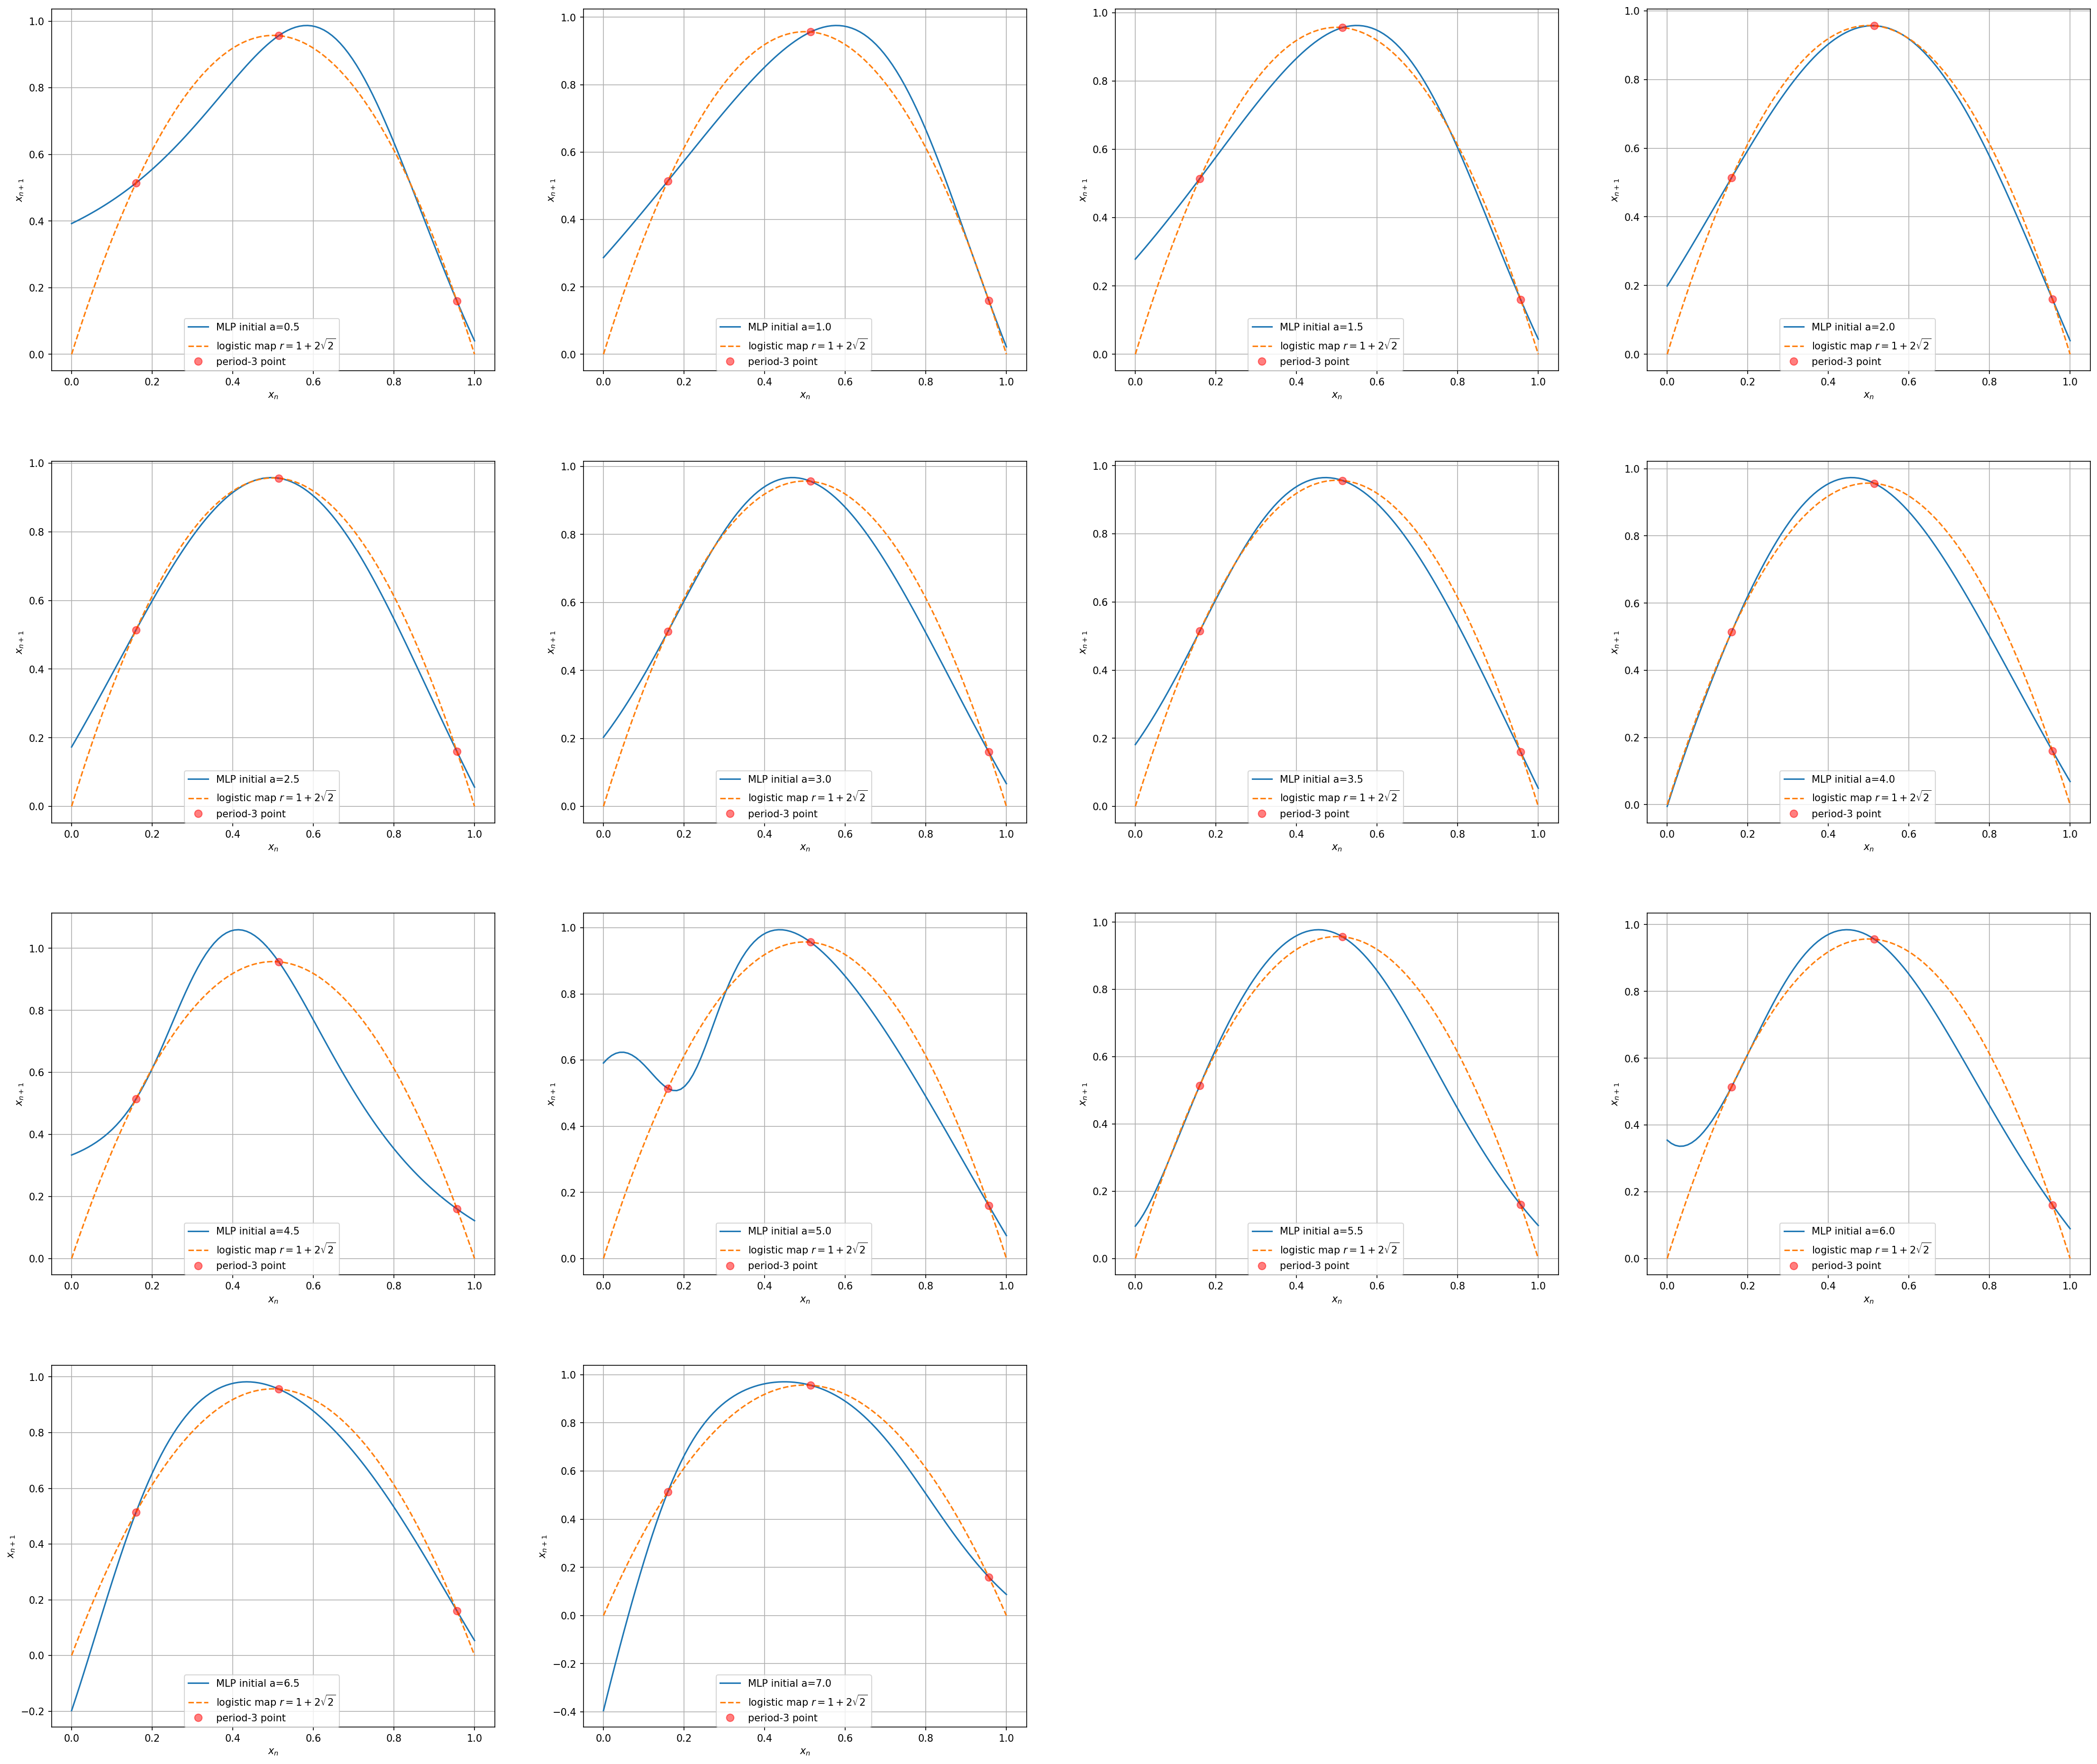

In [71]:
paramtar=np.array(['a=0.5','a=1.0','a=1.5','a=2.0','a=2.5','a=3.0','a=3.5','a=4.0','a=4.5','a=5.0','a=5.5','a=6.0','a=6.5','a=7.0'])
numtar=np.array(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p'])
plt.figure(figsize=(37,32),dpi=150)

for i in range(14):
    plt.subplot(4,4,i+1)
    plt.subplots_adjust(hspace=0.25)
    xx=np.linspace(0,1,100)
    yy0=all_ym[i,999]
    yy=LogisticMapFunction(xx,1+2*np.sqrt(2))
    plt.plot(xx,yy0,label='MLP initial %s'%paramtar[i])
    plt.plot(xx,yy,'--',label='logistic map $r=1+2\sqrt{2}$')
    plt.plot(X0[0],X0[1],'r.',markersize=15,alpha=0.5,label='period-3 point')
    plt.plot(X0[1],X0[2],'r.',markersize=15,alpha=0.5)
    plt.plot(X0[2],X0[3],'r.',markersize=15,alpha=0.5)
    plt.xlabel('$x_n$',size=10)
    plt.ylabel('$x_{n+1}$',size=10)
    plt.legend(loc=(0.3,0))
    #plt.title('(%s)'%numtar[i],y=-0.25)
    plt.grid(True)
